<a href="https://www.kaggle.com/code/tarekmasryo/loan-payback-ps5e11?scriptVersionId=279955928" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 14px 0; font-weight:800; font-size:24px;">
Table of Contents
</h2>

<ul style="margin-top:4px; padding-left:20px;">

  <li><b style="font-size:18px;">Overview &amp; Goal</b>
    <ul style="margin-top:4px; padding-left:18px;">
      <li>Production EDA — Binary Classification (Playground Series S5E11)</li>
      <li>Executive Summary</li>
    </ul>
  </li>

  <li style="margin-top:6px;"><b style="font-size:18px;">Setup &amp; Data Ingestion</b>
    <ul style="margin-top:4px; padding-left:18px;">
      <li>Imports &amp; Basic Setup</li>
      <li>Data Loading &amp; Automatic Column Detection</li>
      <li>Schema Overview</li>
    </ul>
  </li>

  <li style="margin-top:6px;"><b style="font-size:18px;">Data Health &amp; Missingness</b>
    <ul style="margin-top:4px; padding-left:18px;">
      <li>Core Data Health Checks (ID, duplicates, constants, memory)</li>
      <li>Missingness Analysis</li>
    </ul>
  </li>

  <li style="margin-top:6px;"><b style="font-size:18px;">Feature Signal Exploration</b>
    <ul style="margin-top:4px; padding-left:18px;">
      <li>Numeric Signal (Spearman, Profiles)</li>
      <li>Categorical Signal (OOF Target-Rate)</li>
      <li>Outlier Diagnostics</li>
    </ul>
  </li>

  <li style="margin-top:6px;"><b style="font-size:18px;">Train–Test Alignment &amp; Drift</b>
    <ul style="margin-top:4px; padding-left:18px;">
      <li>Train–Test Shift Analysis (PSI / KS / JS)</li>
      <li>Adversarial Validation</li>
    </ul>
  </li>

  <li style="margin-top:6px;"><b style="font-size:18px;">Univariate &amp; Information-Theoretic Signal</b>
    <ul style="margin-top:4px; padding-left:18px;">
      <li>Univariate Scoring (AUC, KS, Spearman, Gini)</li>
      <li>Mutual Information (Top-K)</li>
      <li>Numeric Correlation (Top-K)</li>
      <li>Parallel Coordinates</li>
      <li>WOE &amp; IV (Information Value)</li>
      <li>Unified Signal Ranking</li>
      <li>Stability Check (Bootstrap Spearman)</li>
    </ul>
  </li>

  <li style="margin-top:6px;"><b style="font-size:18px;">Baseline Modeling</b>
    <ul style="margin-top:4px; padding-left:18px;">
      <li>Helper Functions (metrics, gain, thresholds, mapping)</li>
      <li>Tiny Baseline (5-fold OOF Logistic)</li>
    </ul>
  </li>

  <li style="margin-top:6px;"><b style="font-size:18px;">Schema &amp; Compatibility Checks</b>
    <ul style="margin-top:4px; padding-left:18px;">
      <li>Schema Diff &amp; Numeric Ranges</li>
      <li>Unseen Categories in Test</li>
    </ul>
  </li>

  <li style="margin-top:6px;"><b style="font-size:18px;">Artifacts &amp; Handoff</b>
    <ul style="margin-top:4px; padding-left:18px;">
      <li>Artifact Export (JSON + CSV)</li>
      <li>Leak Check &amp; Summary JSON</li>
    </ul>
  </li>

  <li style="margin-top:6px;"><b style="font-size:18px;">Conclusion (EDA)</b>
    <ul style="margin-top:4px; padding-left:18px;">
      <li>Key Insights</li>
      <li>Modeling Implications</li>
    </ul>
  </li>

  <li style="margin-top:6px;"><b style="font-size:18px; color:#38bdf8;">Advanced Modeling &amp; Stacked Ensemble</b>
    <ul style="margin-top:4px; padding-left:18px;">
      <li>Feature Engineering for Gradient Boosting</li>
      <li>Adversarial Re-weighting</li>
      <li>Global XGB CV Search</li>
      <li>Stacked Base Models (XGB + LGBM)</li>
      <li>Meta Models (LR + XGB)</li>
      <li>Final Submissions &amp; Diagnostics</li>
    </ul>
  </li>

</ul>

</div>


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Imports & Basic Setup
</h2>

We load the core Python stack (NumPy, pandas, plotting, and sklearn)  
and configure global settings such as random seed, speed profile, and visual style.

</div>


In [1]:
import os, sys, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display

from scipy.stats import spearmanr, ks_2samp
from scipy.spatial.distance import jensenshannon

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from pandas.plotting import parallel_coordinates

import gc
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb

# EDA Config
SEED = int(os.getenv("SEED", "42"))
np.random.seed(SEED)

SPEED = os.getenv("EDA_SPEED", "mini")  # "mini" | "fast" | "full"
if SPEED == "mini":
    EDA_SAMPLE, TOP_NUM_N, TOP_CAT_N, MI_TOPK = 40_000, 5, 5, 40
elif SPEED == "fast":
    EDA_SAMPLE, TOP_NUM_N, TOP_CAT_N, MI_TOPK = 80_000, 7, 7, 80
else:
    EDA_SAMPLE, TOP_NUM_N, TOP_CAT_N, MI_TOPK = 120_000, 9, 8, 120

DO_EXPORT_FIGS = os.getenv("EDA_EXPORT", "0") == "1"
HEAVY_PLOTS    = os.getenv("EDA_PLOTS_HEAVY", "0") == "1"
EXPORT_DIR     = "figs"

# Style
sns.set_theme(style="whitegrid", palette="rocket")
PALETTE = sns.color_palette("rocket")
BRAND = {
    "blue":   "#1f77b4",
    "orange": "#ff7f0e",
    "gray":   "#6b7280",
}

plt.rcParams.update({
    "text.color":      "black",
    "axes.labelcolor": "black",
    "axes.titlecolor": "black",
    "xtick.color":     "black",
    "ytick.color":     "black",
})


def savefig_mpl(name: str, dpi: int = 220) -> None:
    """Save matplotlib figure if export enabled."""
    if not DO_EXPORT_FIGS:
        return
    os.makedirs(EXPORT_DIR, exist_ok=True)
    path = os.path.join(EXPORT_DIR, f"{name}.png")
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"[FIG] saved: {path}")


print(
    f"[VERSIONS] py={sys.version.split()[0]} | "
    f"pandas={pd.__version__} | numpy={np.__version__} | seaborn={sns.__version__} | "
    f"xgb={xgb.__version__} | lgbm={lgb.__version__}"
)


[VERSIONS] py=3.11.13 | pandas=2.2.3 | numpy=1.26.4 | seaborn=0.12.2 | xgb=2.0.3 | lgbm=4.6.0


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 14px 0; font-weight:800; font-size:22px;">
Data Loading & Automatic Column Detection
</h2>

We locate the competition CSVs from multiple known paths (Kaggle &amp; local), then automatically detect:

<ul style="margin-top:8px; padding-left:20px;">
<li><b>Binary target</b> — inferred from known names or {0,1} patterns</li>
<li><b>ID column</b> — detected from common identifier fields</li>
<li><b>Feature types</b> — split into <span style="color:#7dd3fc;">numeric-like</span> and <span style="color:#fca5a5;">categorical-like</span> columns</li>
</ul>

</div>


In [2]:
DATA_DIRS = [
    "/kaggle/input/playground-series-s5e11",
]

def find_csv_path(name: str) -> str:
    fname = f"{name}.csv"
    # 1) fast path: direct join
    for root in DATA_DIRS:
        if not os.path.exists(root):
            continue
        direct = os.path.join(root, fname)
        if os.path.exists(direct):
            return direct
    # 2) fallback walk (rare)
    for root in DATA_DIRS:
        if not os.path.exists(root):
            continue
        for dirpath, _, files in os.walk(root):
            if fname in files:
                return os.path.join(dirpath, fname)
    raise FileNotFoundError(f"Could not locate {fname} in known locations.")

train_path = find_csv_path("train")
test_path  = find_csv_path("test")
train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

try:
    sample_path = find_csv_path("sample_submission")
    sample_submission = pd.read_csv(sample_path)
except Exception:
    sample_submission, sample_path = None, None

root_detected = os.path.dirname(train_path)
print(f"[DATA] root={root_detected}")
print(f"[DATA] train={train.shape} | test={test.shape} | sample_submission={'yes' if sample_submission is not None else 'no'}")

# Target / ID Detection
CANDIDATE_TARGETS = [
    "loan_paid_back","Class","target","loan_status",
    "is_default","default","label","y"
]

TARGET = None
for c in CANDIDATE_TARGETS:
    if c in train.columns:
        TARGET = c
        break

if TARGET is None:
    bin_cols = []
    for c in train.columns:
        s = pd.to_numeric(train[c], errors="coerce")
        if s.notna().sum() > 0 and set(pd.unique(s.dropna())) <= {0,1}:
            if c.lower() not in ("id","index","uid","row_id"):
                bin_cols.append(c)
    if len(bin_cols) == 1:
        TARGET = bin_cols[0]
    else:
        last = train.columns[-1]
        s = pd.to_numeric(train[last], errors="coerce")
        if set(pd.unique(s.dropna())) <= {0,1}:
            TARGET = last

if TARGET is None:
    raise ValueError("Target could not be inferred. Please specify it manually.")

y_bin = pd.to_numeric(train[TARGET], errors="coerce").astype(int).values

ID_COL = None
for c in train.columns:
    if c.lower() in ("id","index","uid","row_id"):
        ID_COL = c
        break

EXCLUDE = [TARGET] + ([ID_COL] if ID_COL else [])
cols = [c for c in train.columns if c not in EXCLUDE]

def is_numeric_like(s: pd.Series) -> bool:
    co = pd.to_numeric(s, errors="coerce")
    return (co.notna().mean() >= 0.90) and (co.nunique(dropna=True) > 1)

num_cols = [c for c in cols if is_numeric_like(train[c])]
cat_cols = [c for c in cols if c not in num_cols]

print(f"[TARGET] {TARGET} | positives={y_bin.sum()} ({y_bin.mean():.2%})")
print(f"[ID] {ID_COL}")
print(f"[SPLIT] numeric={len(num_cols)}  categorical={len(cat_cols)}")


[DATA] root=/kaggle/input/playground-series-s5e11
[DATA] train=(593994, 13) | test=(254569, 12) | sample_submission=yes
[TARGET] loan_paid_back | positives=474494 (79.88%)
[ID] id
[SPLIT] numeric=5  categorical=6


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Schema Overview
</h2>

A quick structural overview of the dataset, including:

<ul style="margin-top:8px; padding-left:20px;">
<li>File sizes and basic metadata</li>
<li>Memory footprint</li>
<li>Column dtypes and uniqueness</li>
<li>Initial health checks</li>
</ul>

</div>


In [3]:
files = []
for name, path in [
    ("train.csv", train_path),
    ("test.csv",  test_path),
    ("sample_submission.csv", sample_path if sample_submission is not None else None)
]:
    exists = path is not None and os.path.exists(path)
    size_mb = round(os.path.getsize(path)/1024/1024, 2) if exists else None
    files.append({"file": name, "exists": exists, "size_mb": size_mb})

display(pd.DataFrame(files))

n_rows, n_cols = train.shape
mem_mb = train.memory_usage(deep=True).sum() / 1024**2

kpi = pd.DataFrame({
    "metric": ["Train rows","Features excl. ID/target","Positive rate","Memory (MB)"],
    "value": [f"{n_rows:,}", len(cols), f"{y_bin.mean():.2%}", f"{mem_mb:.1f}"]
})
display(kpi)

schema = pd.DataFrame({
    "feature": cols,
    "dtype": train[cols].dtypes.astype(str).tolist(),
    "nunique": train[cols].nunique(dropna=True).tolist(),
    "na_ratio": train[cols].isna().mean().tolist(),
}).sort_values(["dtype","nunique"])

display(HTML("<b>Schema Preview</b>"))
display(schema.head(20))


,file,exists,size_mb
0,train.csv,True,53.39
1,test.csv,True,21.95
2,sample_submission.csv,True,2.19


,metric,value
0,Train rows,"593,994"
1,Features excl. ID/target,11
2,Positive rate,79.88%
3,Memory (MB),250.5


,feature,dtype,nunique,na_ratio
1,debt_to_income_ratio,float64,526,0.0
4,interest_rate,float64,1454,0.0
3,loan_amount,float64,111570,0.0
0,annual_income,float64,119728,0.0
2,credit_score,int64,399,0.0
5,gender,object,3,0.0
6,marital_status,object,4,0.0
7,education_level,object,5,0.0
8,employment_status,object,5,0.0
9,loan_purpose,object,8,0.0


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Missingness Analysis
</h2>

We inspect feature-level missing ratios and visualize null patterns only when required.  
If the dataset contains no missing values, heavy plots are skipped automatically.

</div>


In [4]:
na_ratio = train.isna().mean().sort_values(ascending=False)
max_na = float(na_ratio.max())

if max_na == 0.0:
    print("[MISSINGNESS] No missing values detected. Skipping plots.")
else:
    plt.figure(figsize=(9, 4.5))
    na_ratio.head(15).plot(kind="bar", color=PALETTE)
    plt.ylabel("NA ratio")
    plt.title("Top-15 Missingness")
    plt.tight_layout()
    savefig_mpl("missing_top")
    plt.show()

    top_na = na_ratio[na_ratio > 0].head(min(30, (na_ratio > 0).sum())).index.tolist()
    sample_n = min(len(train), EDA_SAMPLE)
    samp = train[top_na].sample(sample_n, random_state=SEED).isna().astype(int)

    plt.figure(figsize=(10, 4.4))
    sns.heatmap(samp.T, cmap="Blues", cbar=False)
    plt.xlabel("rows (sample)")
    plt.ylabel("features (top missing)")
    plt.title("Null Matrix (sample × features)")
    plt.tight_layout()
    savefig_mpl("missing_heatmap")
    plt.show()

    if (y_bin == 0).sum() > 0 and (y_bin == 1).sum() > 0:
        deltas = []
        for c in top_na[:12]:
            m0 = train[c].isna().values[y_bin == 0].mean()
            m1 = train[c].isna().values[y_bin == 1].mean()
            deltas.append((c, m1 - m0))
        mdf = pd.DataFrame(deltas, columns=["feature","delta"])
        mdf = mdf.sort_values("delta", ascending=False)

        plt.figure(figsize=(9.5, 4.5))
        plt.bar(mdf["feature"], mdf["delta"], color=PALETTE)
        plt.ylabel("m1 - m0")
        plt.xticks(rotation=25, ha="right")
        plt.title("Missingness Difference by Target")
        plt.tight_layout()
        savefig_mpl("missing_by_target")
        plt.show()


[MISSINGNESS] No missing values detected. Skipping plots.


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Numeric Signal (Spearman, Profiles)
</h2>

We quantify numeric predictive strength using:

<ul style="margin-top:8px; padding-left:20px;">
<li><b>Spearman correlation</b></li>
<li><b>Univariate AUC / KS</b></li>
<li><b>20-quantile target-rate profiles</b></li>
</ul>

</div>


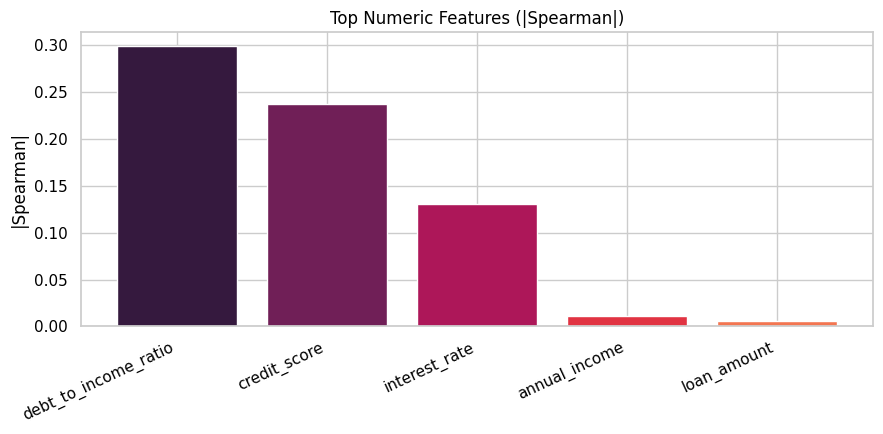

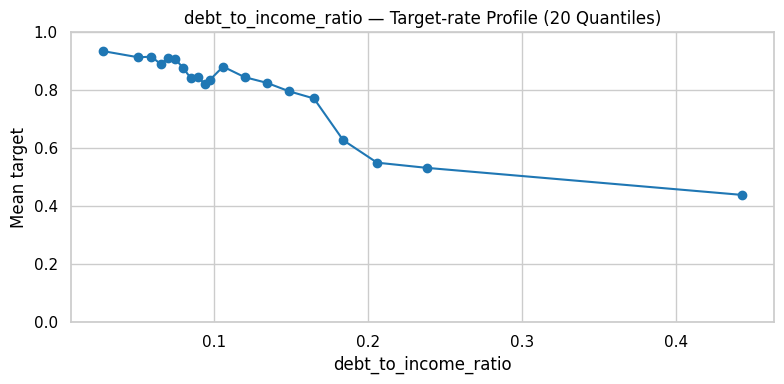

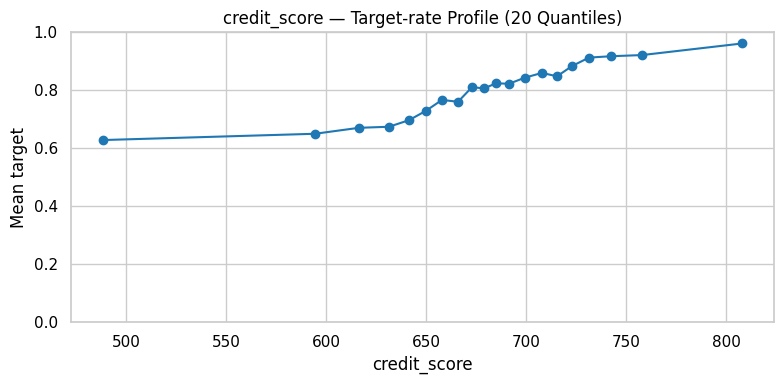

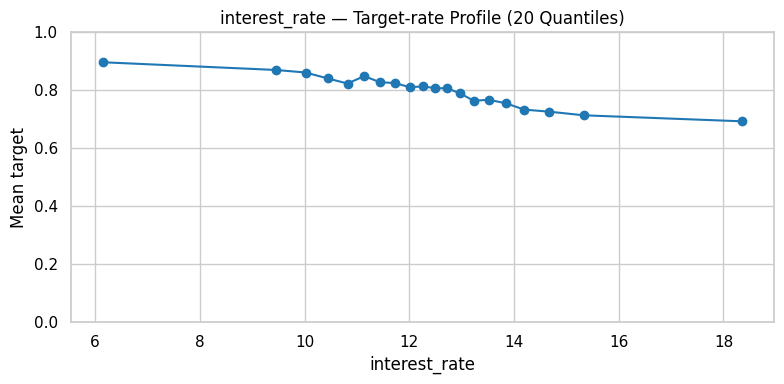

In [5]:
TOP_NUM = []

if len(num_cols) == 0:
    print("[NUMERIC] Skipped: no numeric-like features.")
else:
    num_df = train[num_cols].apply(pd.to_numeric, errors="coerce")
    keep = [c for c in num_cols if num_df[c].notna().sum() > 0 and num_df[c].nunique(dropna=True) > 1]
    num_df = num_df[keep]

    if num_df.shape[1] == 0:
        print("[NUMERIC] Skipped: all numeric columns are constant.")
    else:
        rho_map = {}
        for c in num_df.columns:
            s = num_df[c].fillna(np.nanmedian(num_df[c].values))
            r = spearmanr(s, y_bin).correlation
            r = 0.0 if (r is None or np.isnan(r)) else float(r)
            rho_map[c] = abs(r)

        rho = pd.Series(rho_map).sort_values(ascending=False)
        TOP_NUM = rho.index.tolist()[:TOP_NUM_N]

        plt.figure(figsize=(9, 4.5))
        plt.bar(TOP_NUM, rho.loc[TOP_NUM], color=PALETTE)
        plt.xticks(rotation=25, ha="right")
        plt.ylabel("|Spearman|")
        plt.title("Top Numeric Features (|Spearman|)")
        plt.tight_layout()
        savefig_mpl("numeric_spearman")
        plt.show()

        for c in TOP_NUM[:3]:
            try:
                s = pd.to_numeric(train[c], errors="coerce")
                dfp = pd.DataFrame({"x": s, "y": y_bin}).dropna()
                if dfp["x"].nunique() < 3:
                    continue

                dfp["bin"] = pd.qcut(dfp["x"], q=20, duplicates="drop")
                prof = dfp.groupby("bin", observed=True)["y"].mean().reset_index()
                prof["mid"] = prof["bin"].apply(lambda b: b.mid if hasattr(b, "mid") else np.nan)

                plt.figure(figsize=(8, 4))
                plt.plot(prof["mid"], prof["y"], marker="o", color=BRAND["blue"])
                plt.title(f"{c} — Target-rate Profile (20 Quantiles)")
                plt.xlabel(c)
                plt.ylabel("Mean target")
                plt.ylim(0, 1)
                plt.tight_layout()
                savefig_mpl(f"profile_{c}")
                plt.show()
            except Exception:
                continue


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Categorical Signal (OOF Target-Rate)
</h2>

</div>


,feature,auc,gini,ks,|rho|
3,employment_status,0.778475,0.556949,0.538985,0.390155
5,grade_subgrade,0.656827,0.313654,0.255143,0.217808
2,education_level,0.516063,0.032127,0.029078,0.022369
4,loan_purpose,0.514029,0.028058,0.020044,0.019547
0,gender,0.503765,0.007531,0.009265,0.005255


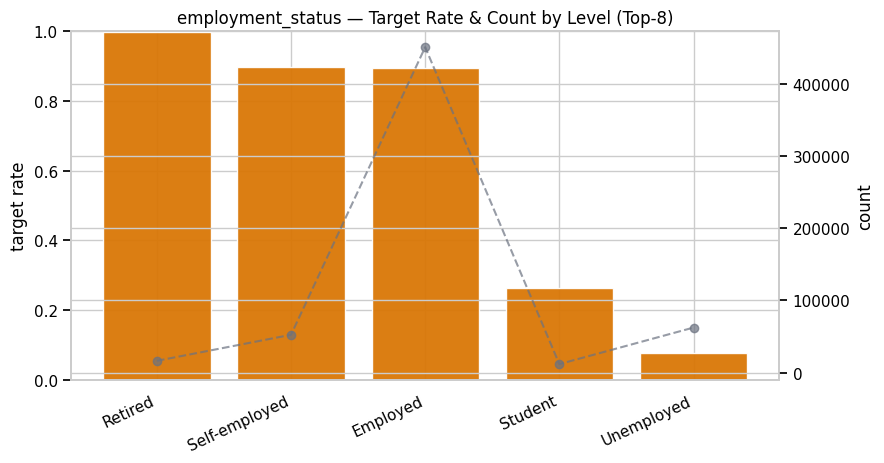

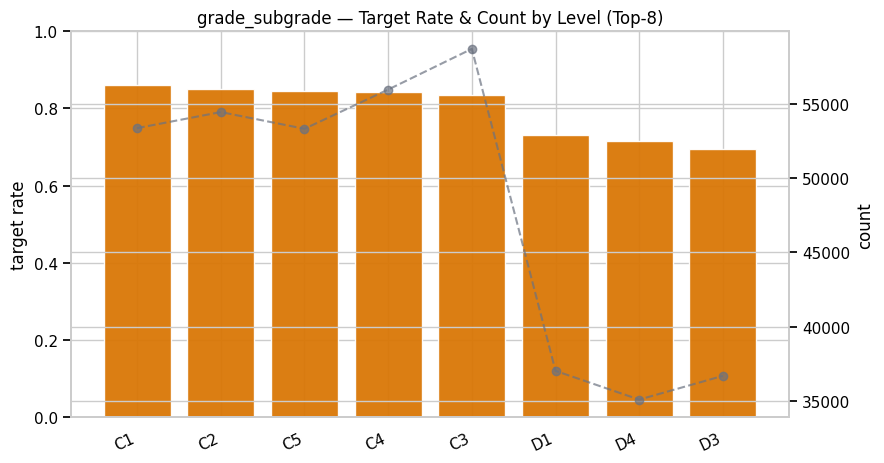

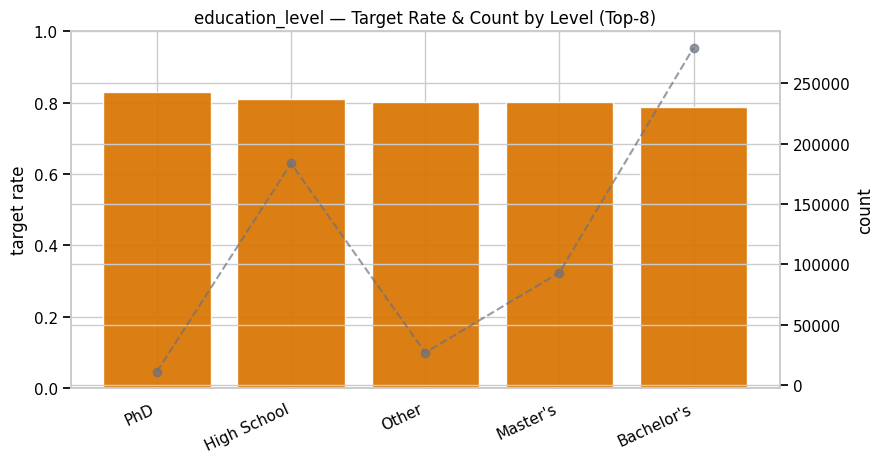

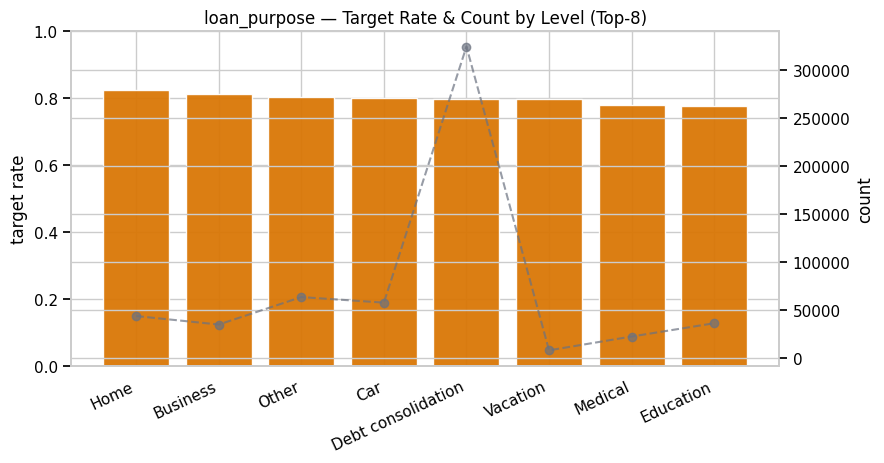

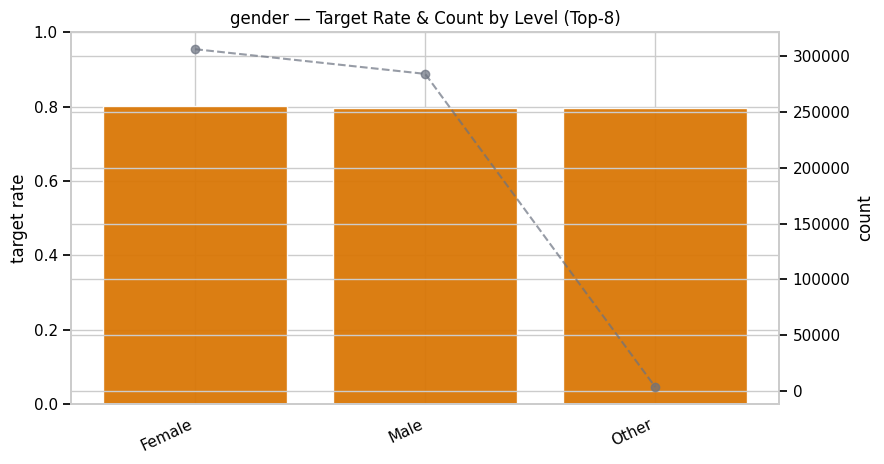

In [6]:
M_SMOOTH = 80.0
CAT_RATE_COLOR = "#d97706"

uni_cat_rows = []
top_cat_levels = {}

if len(cat_cols) == 0:
    print("[CATEGORICAL] Skipped: no categorical-like features.")
else:
    for c in cat_cols:
        s = train[c].astype("object").fillna("__NA__").astype(str)

        oof_r = np.zeros(len(y_bin), dtype=float)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

        for tr_idx, va_idx in skf.split(np.zeros(len(y_bin)), y_bin):
            g = (pd.DataFrame({"x": s.iloc[tr_idx], "y": y_bin[tr_idx]})
                    .groupby("x", observed=True)["y"]
                    .agg(["sum", "count"]))

            prior = float(y_bin[tr_idx].mean())
            mu = (g["sum"] + M_SMOOTH * prior) / (g["count"] + M_SMOOTH)

            mapped = s.iloc[va_idx].map(mu)
            oof_r[va_idx] = mapped.fillna(prior).astype("float32").values

        try:
            auc = float(roc_auc_score(y_bin, oof_r))
            auc = max(auc, 1 - auc)
        except Exception:
            auc = np.nan

        try:
            ks = float(ks_2samp(oof_r[y_bin == 1], oof_r[y_bin == 0]).statistic)
        except Exception:
            ks = np.nan

        try:
            r = spearmanr(oof_r, y_bin).correlation
            rho = 0.0 if (r is None or np.isnan(r)) else abs(float(r))
        except Exception:
            rho = 0.0

        gini = None if pd.isna(auc) else (2 * auc - 1)
        uni_cat_rows.append((c, auc, gini, ks, rho))
        top_cat_levels[c] = s.value_counts().head(8).index.tolist()

    uni_cat = pd.DataFrame(
        uni_cat_rows,
        columns=["feature","auc","gini","ks","|rho|"]
    ).sort_values("auc", ascending=False)

    display(HTML("<b>Top Categorical Features (OOF AUC)</b>"))
    display(uni_cat.head(TOP_CAT_N))

    top_cats = uni_cat["feature"].head(TOP_CAT_N).tolist()
    for c in top_cats:
        s = train[c].astype("object").fillna("__NA__").astype(str)
        levels = top_cat_levels.get(c, s.value_counts().head(8).index.tolist())
        vc = s.value_counts().reindex(levels)
        rt = (pd.DataFrame({"y": y_bin, c: s})
                .groupby(c, observed=True)["y"]
                .mean()
                .reindex(levels))

        dfc = pd.DataFrame({
            "level": levels,
            "count": vc.values,
            "rate": rt.values
        }).sort_values("rate", ascending=False).reset_index(drop=True)

        x = np.arange(len(dfc))
        fig, ax1 = plt.subplots(figsize=(9, 4.8))

        ax1.bar(x, dfc["rate"], color=CAT_RATE_COLOR, alpha=0.95)
        ax1.set_ylabel("target rate")
        ax1.set_ylim(0, 1)

        ax2 = ax1.twinx()
        ax2.plot(
            x,
            dfc["count"],
            marker="o",
            linestyle="--",
            color=BRAND["gray"],
            alpha=0.7,
        )
        ax2.set_ylabel("count")

        ax1.set_xticks(x)
        ax1.set_xticklabels(dfc["level"], rotation=25, ha="right")
        ax1.set_title(f"{c} — Target Rate & Count by Level (Top-8)", color="black")

        fig.tight_layout()
        savefig_mpl(f"cat_rate_{c}")
        plt.show()

    COV_TARGET = 0.95
    rare_rows = []
    for c in cat_cols:
        s = train[c].astype("object").fillna("__NA__").astype(str)
        vc = s.value_counts(normalize=True)
        cum = vc.cumsum()
        k = int((cum < COV_TARGET).sum()) + 1
        rare_rows.append((c, k, vc.shape[0]))

    rare_df = pd.DataFrame(
        rare_rows,
        columns=["feature","top_k_for_95pct","total_levels"]
    ).sort_values("top_k_for_95pct")


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Outlier Diagnostics
</h2>

</div>


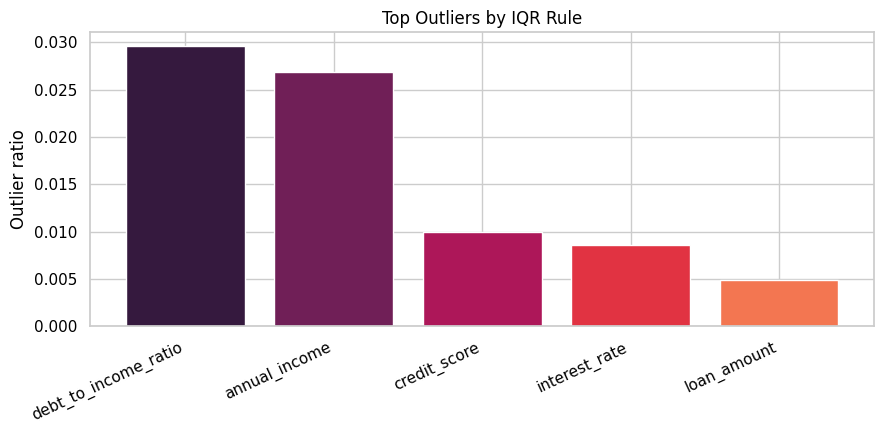

In [7]:
if len(num_cols) == 0:
    print("[OUTLIERS] Skipped: no numeric-like features.")
else:
    out_rows = []
    for c in num_cols:
        s = pd.to_numeric(train[c], errors="coerce")
        if s.notna().sum() == 0:
            continue

        q1, q3 = np.nanpercentile(s, [25, 75])
        iqr = q3 - q1
        lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        iqr_out = float(((s < lo) | (s > hi)).mean())

        mu, sd = np.nanmean(s), np.nanstd(s)
        z_out = float(np.mean(np.abs((s - mu) / (sd + 1e-9)) > 3)) if sd > 0 else 0.0

        out_rows.append((c, iqr_out, z_out))

    outdf = (
        pd.DataFrame(out_rows, columns=["feature","iqr_outlier_ratio","z3_outlier_ratio"])
        .sort_values("iqr_outlier_ratio", ascending=False)
        .head(12)
    )

    plt.figure(figsize=(9, 4.5))
    plt.bar(outdf["feature"], outdf["iqr_outlier_ratio"], color=PALETTE)
    plt.title("Top Outliers by IQR Rule")
    plt.ylabel("Outlier ratio")
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    savefig_mpl("outliers_iqr")
    plt.show()


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Train–Test Shift Analysis
</h2>

</div>


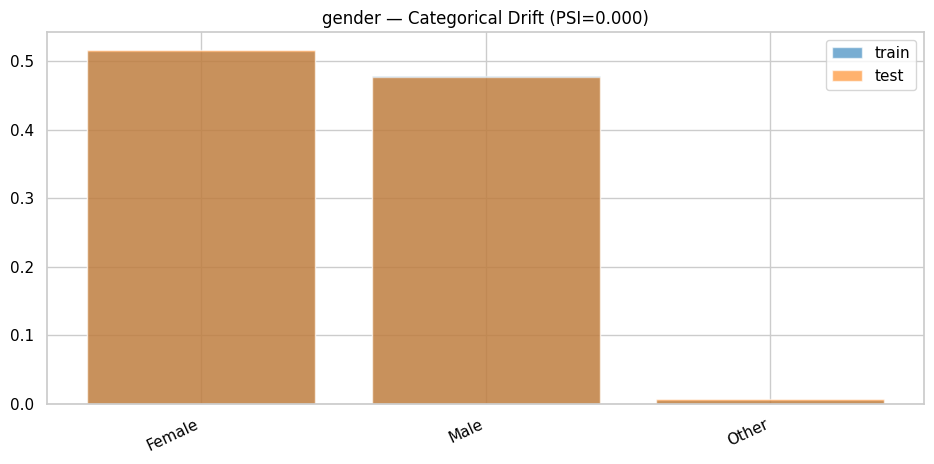

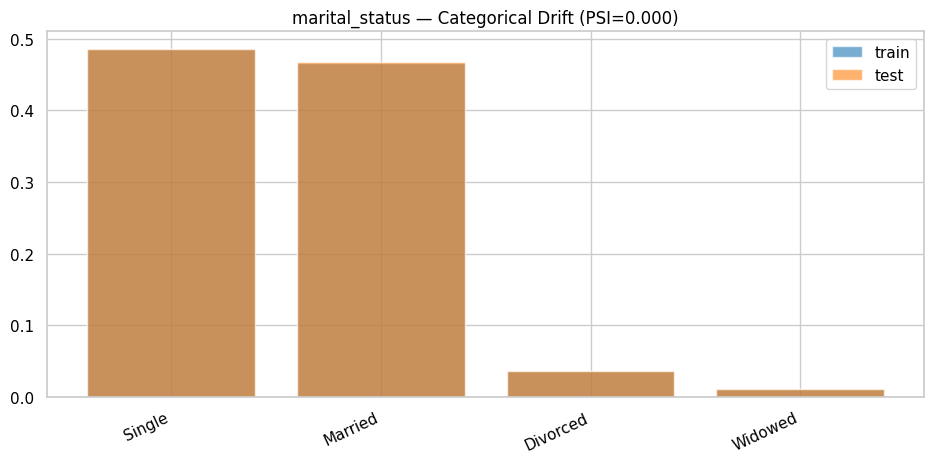

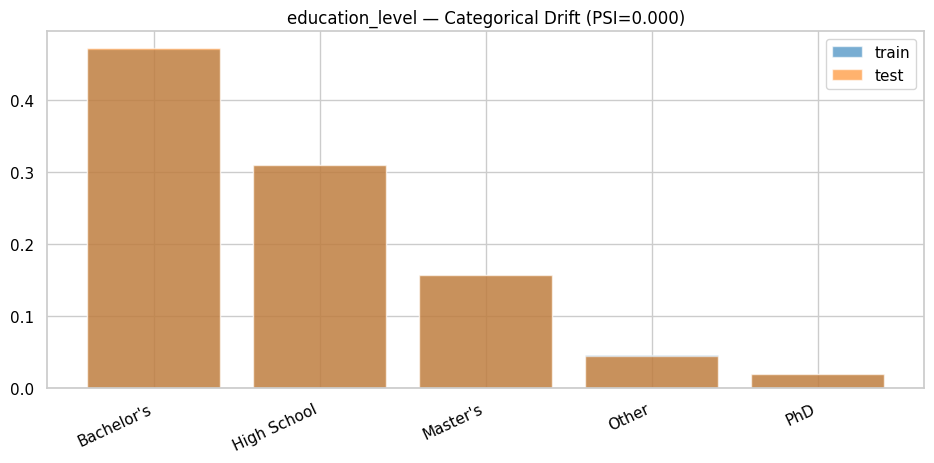

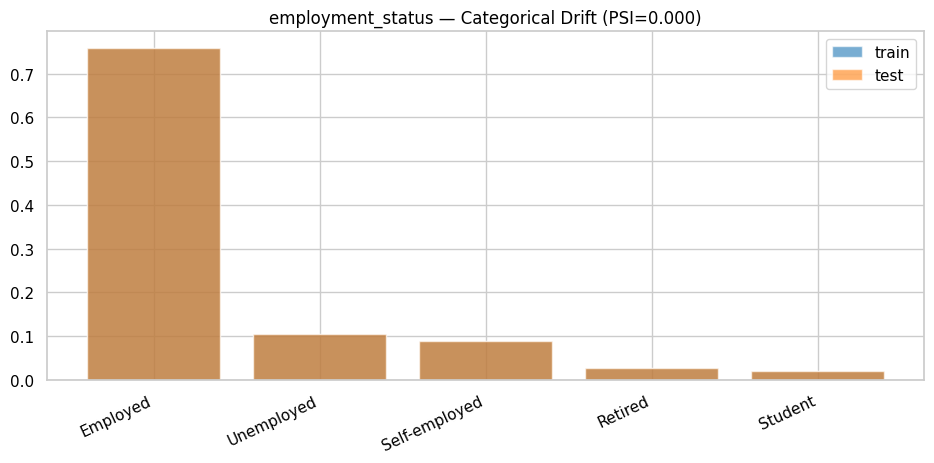

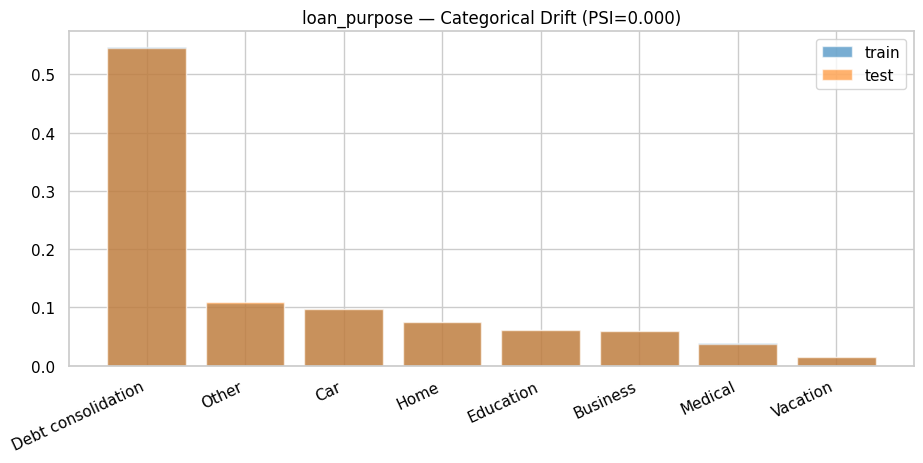

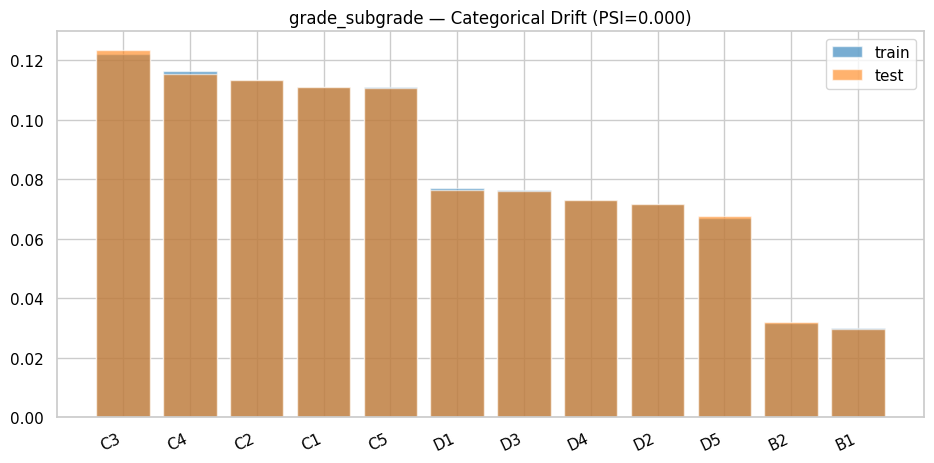

,feature,psi,severity
5,grade_subgrade,0.000049,low
4,loan_purpose,0.000030,low
2,education_level,0.000011,low
0,gender,0.000010,low
1,marital_status,0.000008,low
3,employment_status,0.000005,low


,feature,psi,ks,js,severity
1,debt_to_income_ratio,0.000161,0.002063,0.004490,low
2,credit_score,0.000142,0.001877,0.004207,low
4,interest_rate,0.000116,0.002596,0.003802,low
3,loan_amount,0.000108,0.001703,0.003674,low
0,annual_income,0.000069,0.001902,0.002927,low


In [8]:
## Categorical Drift (PSI)
drift_cat = None
cat_rows = []

if len(cat_cols) == 0:
    print("[DRIFT-CAT] Skipped: no categorical-like features.")
else:
    cand = [c for c in cat_cols if c in test.columns]

    for c in cand[:min(6, len(cand))]:
        tr = train[c].astype("object").fillna("__NA__").astype(str)
        te = test[c].astype("object").fillna("__NA__").astype(str)

        vc_tr = tr.value_counts(normalize=True)
        vc_te = te.value_counts(normalize=True)

        all_idx = (
            (vc_tr.add(vc_te, fill_value=0.0))
            .sort_values(ascending=False)
            .head(12).index.tolist()
        )

        P = vc_tr.reindex(all_idx).fillna(0.0).values + 1e-6
        Q = vc_te.reindex(all_idx).fillna(0.0).values + 1e-6

        psi = float(np.sum((Q - P) * np.log(Q / P)))
        cat_rows.append((c, psi))

        plt.figure(figsize=(9.5, 4.8))
        plt.bar(all_idx, P / P.sum(), alpha=0.6, label="train", color=BRAND["blue"])
        plt.bar(all_idx, Q / Q.sum(), alpha=0.6, label="test",  color=BRAND["orange"])
        plt.title(f"{c} — Categorical Drift (PSI={abs(psi):.3f})")
        plt.xticks(rotation=25, ha="right")
        plt.legend()
        plt.tight_layout()
        savefig_mpl(f"psi_cat_{c}")
        plt.show()

    if len(cat_rows):
        def _sev(x):
            ax = abs(x)
            return "low" if ax < 0.1 else ("medium" if ax < 0.25 else "high")

        drift_cat = (
            pd.DataFrame(cat_rows, columns=["feature","psi"])
            .assign(severity=lambda d: d["psi"].apply(_sev))
        )

        display(HTML("<b>Categorical Drift — Top PSI</b>"))
        display(drift_cat.sort_values("psi", ascending=False).head(10))

## Numeric Drift (PSI / KS / JS)
drift_num = None
rows = []

if len(num_cols) == 0:
    print("[DRIFT-NUM] Skipped: no numeric-like features.")
else:
    for c in num_cols:
        if c not in test.columns:
            continue

        a = pd.to_numeric(train[c], errors="coerce")
        b = pd.to_numeric(test[c], errors="coerce")

        if a.notna().sum() < 200 or b.notna().sum() < 200:
            continue

        edges = np.quantile(a.dropna(), np.linspace(0, 1, 21))
        edges = np.unique(edges)
        if len(edges) < 3:
            continue

        Pa, _ = np.histogram(a.dropna(), bins=edges)
        Pb, _ = np.histogram(b.dropna(), bins=edges)
        Pa = Pa.astype(float); Pb = Pb.astype(float)
        Pa /= (Pa.sum() + 1e-9)
        Pb /= (Pb.sum() + 1e-9)

        psi = float(np.sum((Pa - Pb) * np.log((Pa + 1e-9) / (Pb + 1e-9))))
        ks = float(ks_2samp(a.dropna(), b.dropna()).statistic)
        jsd = float(jensenshannon(Pa, Pb))

        rows.append((c, psi, ks, jsd))

    if rows:
        drift_num = pd.DataFrame(rows, columns=["feature","psi","ks","js"])

        sev = pd.cut(
            drift_num["psi"].abs(),
            bins=[-np.inf, 0.1, 0.25, np.inf],
            labels=["low","medium","high"]
        )

        drift_num["severity"] = pd.Categorical(sev, categories=["low","medium","high"], ordered=True)
        drift_num = drift_num.sort_values(["severity","psi"], ascending=[False, False])

        display(HTML("<b>Numeric Drift — PSI / KS / JS</b>"))
        display(drift_num.head(15))


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Univariate Scoring (AUC, KS, Spearman, Gini)
</h2>

</div>


,feature,auc,gini,ks,|rho|,type
8,employment_status,0.778475,0.556949,0.538985,0.390155,cat
1,debt_to_income_ratio,0.715270,0.430540,0.340915,0.298957,num
2,credit_score,0.671153,0.342306,0.255156,0.237685,num
10,grade_subgrade,0.656827,0.313654,0.255143,0.217808,cat
4,interest_rate,0.594171,0.188342,0.139802,0.130776,num
7,education_level,0.516063,0.032127,0.029078,0.022369,cat
9,loan_purpose,0.514029,0.028058,0.020044,0.019547,cat
0,annual_income,0.508128,0.016257,0.018231,0.011288,num
3,loan_amount,0.503957,0.007913,0.019772,0.005495,num
5,gender,0.503765,0.007531,0.009265,0.005255,cat


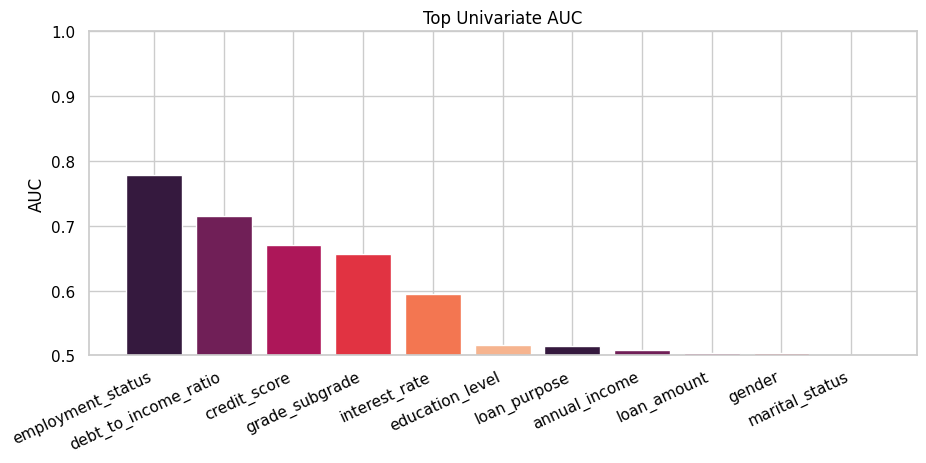

In [9]:
uni_rows = []

# Numeric
for c in num_cols:
    s = pd.to_numeric(train[c], errors="coerce")
    med = np.nanmedian(s)
    s = s.fillna(med)

    try:
        auc = float(roc_auc_score(y_bin, s))
        auc = max(auc, 1 - auc)
    except Exception:
        auc = np.nan

    try:
        ks = float(ks_2samp(s[y_bin == 1], s[y_bin == 0]).statistic)
    except Exception:
        ks = np.nan

    try:
        r = spearmanr(s, y_bin).correlation
        rho = 0.0 if (r is None or np.isnan(r)) else abs(float(r))
    except Exception:
        rho = 0.0

    gini = None if pd.isna(auc) else (2 * auc - 1)
    uni_rows.append((c, auc, gini, ks, rho, "num"))

# Categorical (from uni_cat_rows)
for c, auc, gini, ks, rho in uni_cat_rows:
    uni_rows.append((c, auc, gini, ks, rho, "cat"))

uni = pd.DataFrame(
    uni_rows,
    columns=["feature","auc","gini","ks","|rho|","type"]
).sort_values("auc", ascending=False)

display(HTML("<b>Univariate Scores — Top Features</b>"))
display(uni.head(15))

top_uni = uni.head(12)
plt.figure(figsize=(9.5, 4.8))
plt.bar(top_uni["feature"], top_uni["auc"], color=PALETTE)
plt.ylabel("AUC")
plt.ylim(0.5, 1.0)
plt.xticks(rotation=25, ha="right")
plt.title("Top Univariate AUC")
plt.tight_layout()
savefig_mpl("uni_auc_top")
plt.show()


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Mutual Information (Top-K)
</h2>

</div>


,feature,mi
0,employment_status,0.175941
1,debt_to_income_ratio,0.079239
2,credit_score,0.033957
3,grade_subgrade,0.026769
8,loan_amount,0.013281
4,interest_rate,0.012139
7,annual_income,0.010852
6,loan_purpose,0.000331
5,education_level,0.000325
9,gender,0.000028


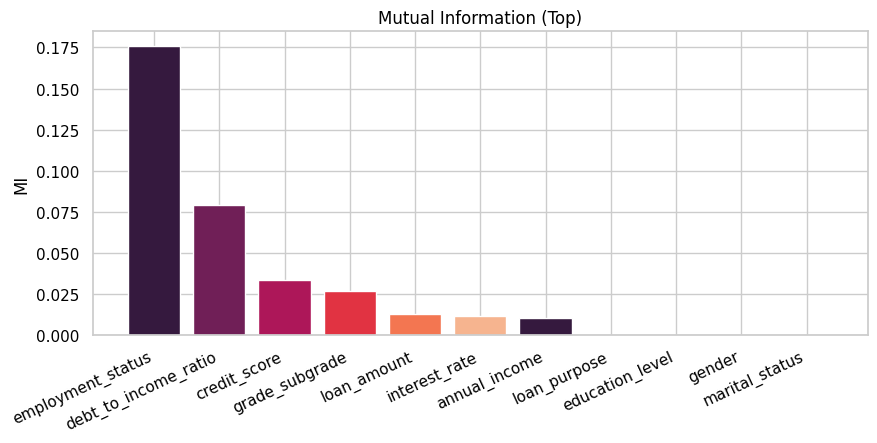

In [10]:
mi_df = None
rank_seed = uni["feature"].head(MI_TOPK).tolist()
cand = [c for c in rank_seed if c in train.columns]

if len(cand) == 0:
    print("[MI] Skipped: no candidate features.")
else:
    X_mi = pd.DataFrame(index=train.index)
    for c in cand:
        if c in num_cols:
            s = pd.to_numeric(train[c], errors="coerce")
            X_mi[c] = s.fillna(np.nanmedian(s)).astype("float32")
        else:
            s = train[c].astype("object").fillna("__NA__").astype("category")
            X_mi[c] = s.cat.codes.astype("int32")

    disc = [c not in num_cols for c in X_mi.columns]
    mi = mutual_info_classif(X_mi, y_bin, discrete_features=disc, random_state=SEED)

    mi_df = pd.DataFrame({"feature": X_mi.columns, "mi": mi}).sort_values("mi", ascending=False)

    display(HTML("<b>Mutual Information — Top Features</b>"))
    display(mi_df.head(12))

    top_mi = mi_df.head(12)
    plt.figure(figsize=(9, 4.6))
    plt.bar(top_mi["feature"], top_mi["mi"], color=PALETTE)
    plt.ylabel("MI")
    plt.xticks(rotation=25, ha="right")
    plt.title("Mutual Information (Top)")
    plt.tight_layout()
    savefig_mpl("mi_top")
    plt.show()


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Numeric Correlation (Top-K)
</h2>

</div>


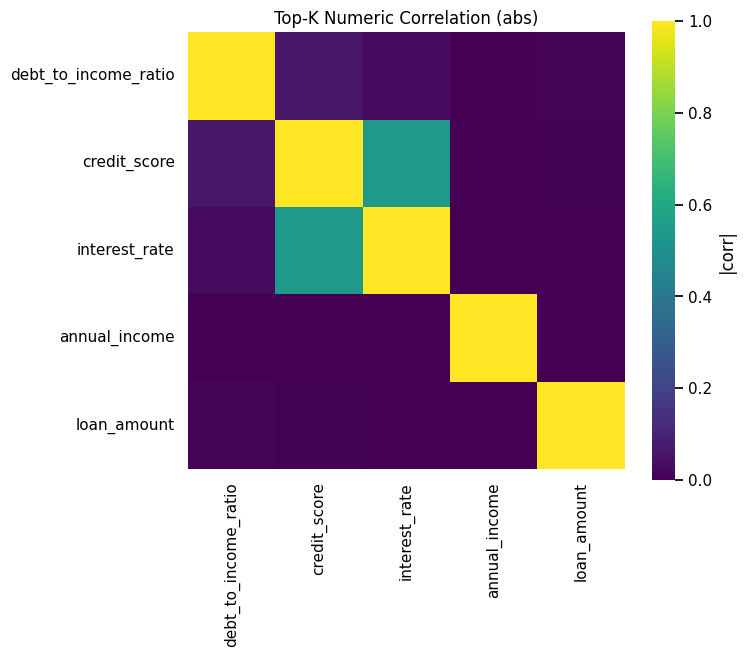

In [11]:
K = min(10, len(num_cols))
pick_corr = TOP_NUM[:K] if len(TOP_NUM) else num_cols[:K]

if len(pick_corr) < 2:
    print("[CORR] Skipped: need at least 2 numeric features.")
else:
    corr = train[pick_corr].apply(pd.to_numeric, errors="coerce").corr().abs()

    plt.figure(figsize=(7.6, 6.6))
    sns.heatmap(
        corr,
        cmap="viridis",
        vmin=0, vmax=1,
        square=True,
        cbar_kws={"label": "|corr|"}
    )
    plt.title("Top-K Numeric Correlation (abs)")
    plt.tight_layout()
    savefig_mpl("corr_topk")
    plt.show()


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Parallel Coordinates
</h2>

</div>


In [12]:
if not HEAVY_PLOTS:
    print("[PARCOORD] Skipped: HEAVY_PLOTS=0")
else:
    if len(num_cols) < 3:
        print("[PARCOORD] Skipped: need at least 3 numeric features.")
    else:
        order = TOP_NUM if len(TOP_NUM) else num_cols
        cols_pc = [c for c in order if c in train.columns][:5]

        df_pc = pd.DataFrame({c: pd.to_numeric(train[c], errors="coerce") for c in cols_pc})
        df_pc["y"] = y_bin

        df_pc[cols_pc] = df_pc[cols_pc].fillna(df_pc[cols_pc].median())

        if len(df_pc) > 6000:
            df_pc = df_pc.sample(6000, random_state=SEED)

        scaler = MinMaxScaler()
        df_pc[cols_pc] = scaler.fit_transform(df_pc[cols_pc])
        tmp = df_pc[cols_pc + ["y"]].copy()
        tmp["y"] = tmp["y"].astype(str)

        plt.figure(figsize=(10, 5))
        parallel_coordinates(tmp, "y", color=[BRAND["blue"], BRAND["orange"]], alpha=0.22, linewidth=0.8)
        plt.title("Parallel Coordinates (scaled)")
        plt.margins(x=0.02)
        plt.tight_layout()
        savefig_mpl("parallel_coordinates")
        plt.show()


[PARCOORD] Skipped: HEAVY_PLOTS=0


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
WOE &amp; IV (Information Value)
</h2>

</div>


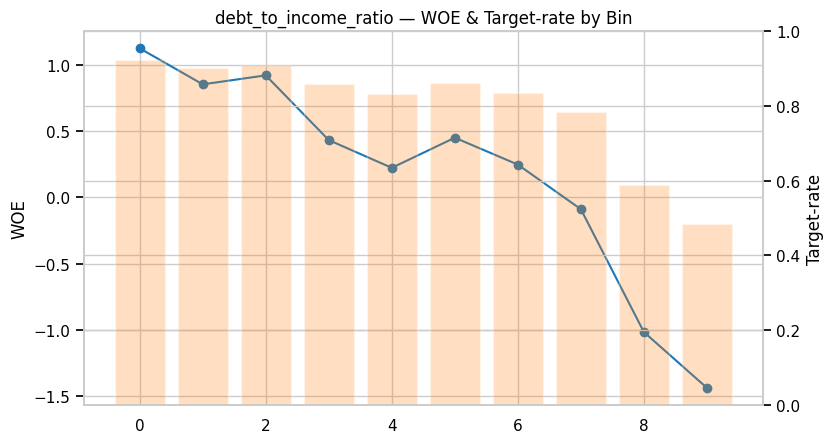

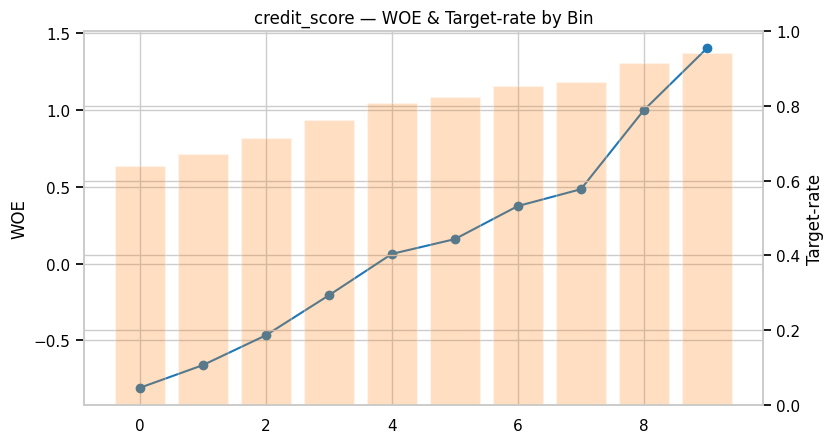

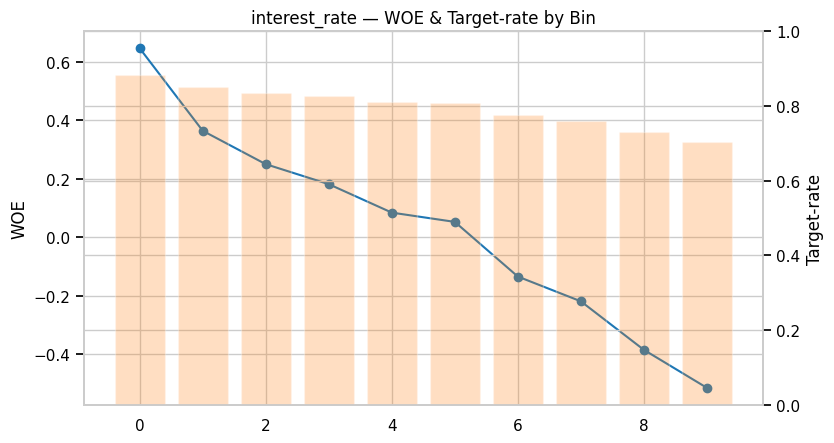

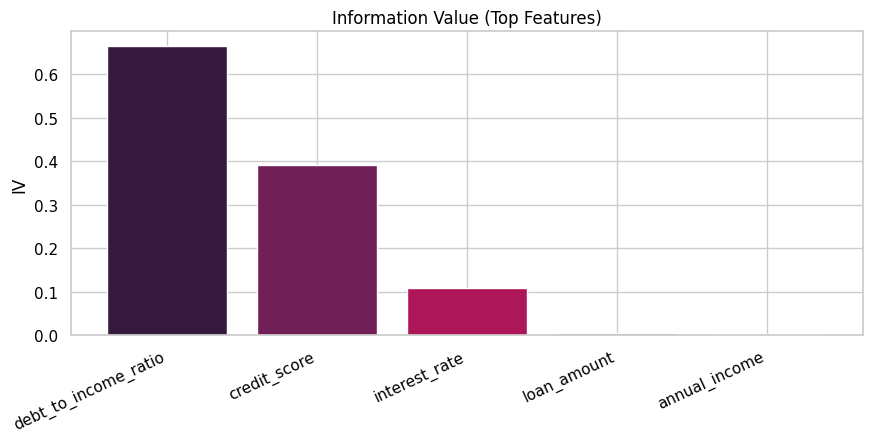

In [13]:
iv_df = None
EPS = 1e-6

if len(num_cols) == 0:
    print("[WOE/IV] Skipped: no numeric features.")
else:
    base_list = TOP_NUM if len(TOP_NUM) else num_cols
    MIN_BIN_FRAC = 0.005
    MIN_BIN = max(1, int(MIN_BIN_FRAC * len(train)))

    iv_rows = []
    plotted = 0

    for c in base_list[:min(6, len(base_list))]:
        x = pd.to_numeric(train[c], errors="coerce")
        y = pd.Series(y_bin, index=train.index)

        tmp = pd.DataFrame({"x": x, "y": y}).dropna()
        if tmp["x"].nunique() < 3:
            continue

        q_bins = min(10, tmp["x"].nunique())
        try:
            tmp["bin"] = pd.qcut(tmp["x"], q=q_bins, labels=False, duplicates="drop")
        except Exception:
            continue

        g = tmp.groupby("bin")["y"].agg(["sum","count"])
        g["neg"] = g["count"] - g["sum"]

        g = g[g["count"] >= MIN_BIN]
        if len(g) == 0:
            continue

        P = g["sum"].sum()
        N = g["neg"].sum()
        if P <= 0 or N <= 0:
            continue

        g["rate"] = g["sum"] / g["count"].clip(1)
        g["woe"] = np.log(
            ((g["sum"] + EPS) / max(P, EPS)) /
            ((g["neg"] + EPS) / max(N, EPS))
        )
        g["iv"] = (
            ((g["sum"] + EPS) / max(P, EPS)) -
            ((g["neg"] + EPS) / max(N, EPS))
        ) * g["woe"]

        iv_val = float(g["iv"].sum())
        iv_rows.append((c, iv_val))

        if plotted < 3:
            fig, ax1 = plt.subplots(figsize=(8.5, 4.6))
            ax2 = ax1.twinx()
            ax1.plot(g.index, g["woe"], marker="o", color=BRAND["blue"], label="WOE")
            ax2.bar(g.index, g["rate"], alpha=0.25, color=BRAND["orange"], label="Rate")
            ax1.set_ylabel("WOE")
            ax2.set_ylabel("Target-rate")
            ax2.set_ylim(0, 1)
            plt.title(f"{c} — WOE & Target-rate by Bin")
            plt.tight_layout()
            savefig_mpl(f"iv_{c}")
            plt.show()
            plotted += 1

    if len(iv_rows):
        iv_df = pd.DataFrame(iv_rows, columns=["feature","iv"]).sort_values("iv", ascending=False)
        plt.figure(figsize=(9, 4.6))
        plt.bar(iv_df["feature"], iv_df["iv"], color=PALETTE)
        plt.ylabel("IV")
        plt.xticks(rotation=25, ha="right")
        plt.title("Information Value (Top Features)")
        plt.tight_layout()
        savefig_mpl("iv_top")
        plt.show()
    else:
        print("[WOE/IV] No valid IV features.")


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Unified Signal Ranking
</h2>

</div>


In [14]:
tables = []

if isinstance(uni, pd.DataFrame) and len(uni):
    u = uni[["feature", "auc", "gini", "ks", "|rho|"]].copy()
    u["mi"] = np.nan
    u["iv"] = np.nan
    u = u[["feature","auc","gini","ks","|rho|","mi","iv"]]
    tables.append(u)

if isinstance(mi_df, pd.DataFrame) and len(mi_df):
    m = mi_df[["feature", "mi"]].copy()
    m["auc"] = np.nan
    m["gini"] = np.nan
    m["ks"] = np.nan
    m["|rho|"] = np.nan
    m["iv"] = np.nan
    m = m[["feature","auc","gini","ks","|rho|","mi","iv"]]
    tables.append(m)

if isinstance(iv_df, pd.DataFrame) and len(iv_df):
    v = iv_df[["feature", "iv"]].copy()
    v["auc"] = np.nan
    v["gini"] = np.nan
    v["ks"] = np.nan
    v["|rho|"] = np.nan
    v["mi"] = np.nan
    v = v[["feature","auc","gini","ks","|rho|","mi","iv"]]
    tables.append(v)

if tables:
    Z = (
        pd.concat(tables, ignore_index=True)
        .groupby("feature", as_index=False)
        .agg("max")
    )

if tables:
    Z = pd.concat(tables, ignore_index=True).groupby("feature").agg("max")

    for c in ["auc","ks","|rho|","mi","iv"]:
        Z[c] = pd.to_numeric(Z[c], errors="coerce").rank(pct=True)

    Z["composite"] = Z[["auc","ks","|rho|","mi","iv"]].fillna(0).mean(axis=1)
    topZ = Z.sort_values("composite", ascending=False).head(15)

    display(HTML("<b>Unified Signal Ranking (Top-15)</b>"))
    display(topZ)
else:
    print("[UNIFIED] Skipped: no tables to combine.")


,auc,gini,ks,|rho|,mi,iv,composite
feature,,,,,,,
debt_to_income_ratio,0.909091,0.430540,0.909091,0.909091,0.909091,1.0,0.927273
credit_score,0.818182,0.342306,0.818182,0.818182,0.818182,0.8,0.814545
employment_status,1.000000,0.556949,1.000000,1.000000,1.000000,NaN,0.800000
interest_rate,0.636364,0.188342,0.636364,0.636364,0.545455,0.6,0.610909
grade_subgrade,0.727273,0.313654,0.727273,0.727273,0.727273,NaN,0.581818
loan_amount,0.272727,0.007913,0.363636,0.272727,0.636364,0.4,0.389091
education_level,0.545455,0.032127,0.545455,0.545455,0.272727,NaN,0.381818
loan_purpose,0.454545,0.028058,0.454545,0.454545,0.363636,NaN,0.345455
annual_income,0.363636,0.016257,0.272727,0.363636,0.454545,0.2,0.330909


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Stability Check (Bootstrap Spearman)
</h2>

</div>


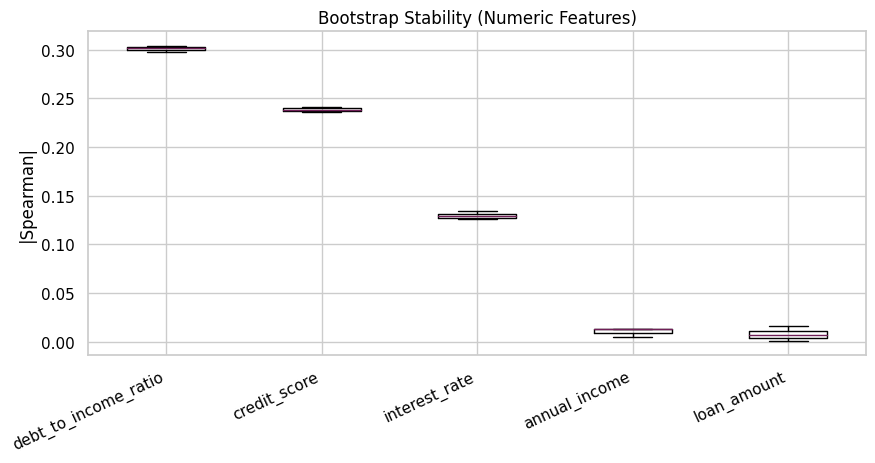

In [15]:
if len(num_cols) <= 1:
    print("[STABILITY] Skipped: need at least 2 numeric features.")
else:
    boot = 3
    pick_stab = TOP_NUM[:min(6, len(TOP_NUM))] if len(TOP_NUM) else num_cols[:min(6, len(num_cols))]
    sample_n = min(len(train), EDA_SAMPLE)

    rho_map = {c: [] for c in pick_stab}

    for b in range(boot):
        rng = np.random.default_rng(SEED + b)
        idx = rng.choice(len(train), size=sample_n, replace=True)
        yb = y_bin[idx]

        for c in pick_stab:
            s = pd.to_numeric(train[c].iloc[idx], errors="coerce")
            s = s.fillna(np.nanmedian(s))
            r = spearmanr(s, yb).correlation
            r = 0 if (r is None or np.isnan(r)) else abs(float(r))
            rho_map[c].append(r)

    labels = list(rho_map.keys())
    values = [rho_map[c] for c in labels]

    plt.figure(figsize=(9, 4.8))
    plt.boxplot(values, labels=labels, showfliers=False)
    plt.ylabel("|Spearman|")
    plt.title("Bootstrap Stability (Numeric Features)")
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    savefig_mpl("bootstrap_spearman")
    plt.show()


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Helper Functions
</h2>

</div>


In [16]:
def ks_stat(y_true, y_score):
    return float(ks_2samp(y_score[y_true==1], y_score[y_true==0]).statistic)

def top_decile_capture(y_true, y_score, frac=0.10):
    n = len(y_true)
    k = max(1, int(frac * n))
    idx = np.argsort(-y_score)[:k]
    return float(y_true[idx].sum()) / max(1, float(y_true.sum()))

def threshold_at_precision(y_true, y_score, target_prec=0.90):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    idx = np.where(prec >= target_prec)[0]
    if len(idx) == 0 or len(thr) == 0:
        return None, None
    i = min(idx[0], len(thr)-1)
    return float(thr[i]), float(rec[i])

def quantile_map(ref_scores, new_scores, q=1001):
    qs = np.linspace(0, 1, q)
    ref_q = np.quantile(ref_scores, qs)
    new_q = np.quantile(new_scores, qs)
    return np.interp(new_scores, new_q, ref_q)


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Tiny Baseline (5-fold OOF Logistic)
</h2>

</div>


[BASELINE][fold 1] AUC = 0.775728
[BASELINE][fold 2] AUC = 0.774231
[BASELINE][fold 3] AUC = 0.772445
[BASELINE][fold 4] AUC = 0.770816
[BASELINE][fold 5] AUC = 0.772356
[BASELINE] OOF AUC=0.773113 | mean=0.773115 ± 0.001696
[BASELINE] Gini=0.546225 | KS=0.403168 | Top10% Capture=0.1224
[BASELINE] Thr(P≥0.90)=0.5107, recall=0.7182


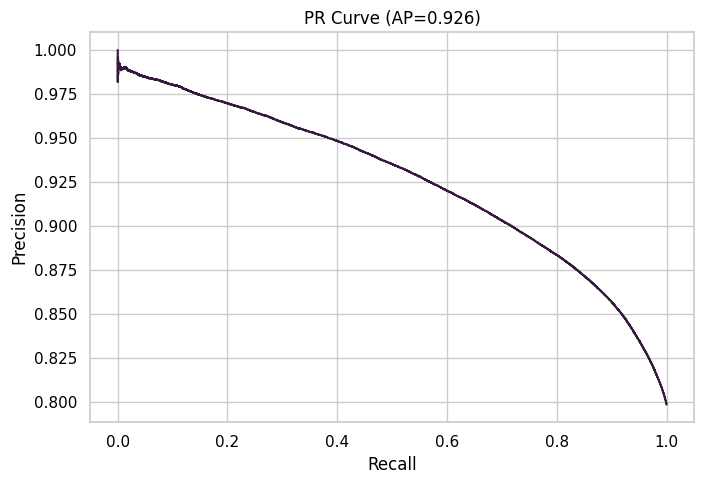

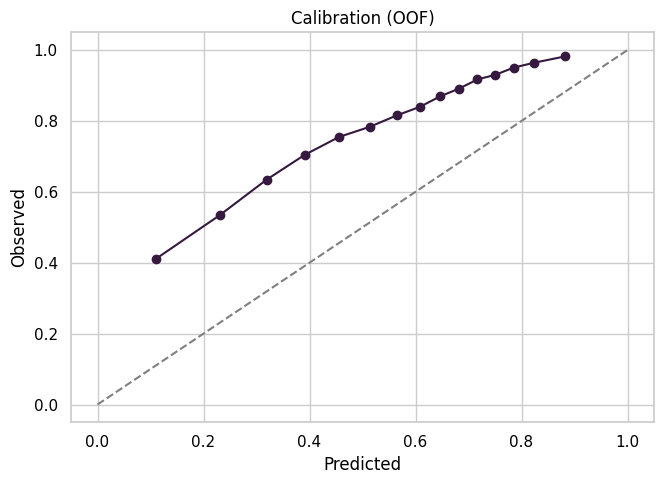

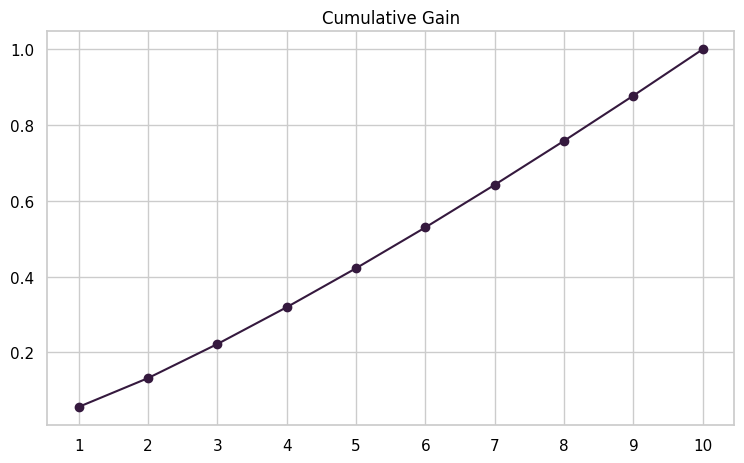

In [17]:
HAS_OOF = False
base_feats = TOP_NUM if len(TOP_NUM) else num_cols[:10]

if len(base_feats) >= 2:
    use = [c for c in base_feats if train[c].nunique(dropna=True) > 1]
    if len(use) >= 2:
        Xb = pd.DataFrame({c: pd.to_numeric(train[c], errors="coerce") for c in use})
        Xb = Xb.fillna(Xb.median())

        scaler = StandardScaler()
        Xs = scaler.fit_transform(Xb)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        oof = np.zeros(len(train), dtype=float)
        fold_scores = []

        for fold, (tr_idx, va_idx) in enumerate(cv.split(Xs, y_bin), 1):
            clf = LogisticRegression(
                max_iter=300,
                class_weight="balanced",
                solver="lbfgs"
            )
            clf.fit(Xs[tr_idx], y_bin[tr_idx])
            p_va = clf.predict_proba(Xs[va_idx])[:, 1]
            oof[va_idx] = p_va
            score = roc_auc_score(y_bin[va_idx], p_va)
            fold_scores.append(score)
            print(f"[BASELINE][fold {fold}] AUC = {score:.6f}")

        oof_auc = roc_auc_score(y_bin, oof)
        oof_gini = 2 * oof_auc - 1
        oof_ks = ks_stat(y_bin, oof)
        cap10 = top_decile_capture(y_bin, oof)
        t90, r90 = threshold_at_precision(y_bin, oof, 0.90)

        print(f"[BASELINE] OOF AUC={oof_auc:.6f} | mean={np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}")
        print(f"[BASELINE] Gini={oof_gini:.6f} | KS={oof_ks:.6f} | Top10% Capture={cap10:.4f}")
        if t90 is not None:
            print(f"[BASELINE] Thr(P≥0.90)={t90:.4f}, recall={r90:.4f}")

        HAS_OOF = True

        prec, rec, thr = precision_recall_curve(y_bin, oof)
        ap = average_precision_score(y_bin, oof)

        plt.figure(figsize=(7.2, 5.0))
        plt.plot(rec, prec)
        plt.title(f"PR Curve (AP={ap:.3f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.tight_layout()
        savefig_mpl("baseline_pr")
        plt.show()

        from sklearn.calibration import calibration_curve
        prob_true, prob_pred = calibration_curve(y_bin, oof, n_bins=15, strategy="quantile")

        plt.figure(figsize=(6.8, 5.0))
        plt.plot(prob_pred, prob_true, marker="o")
        plt.plot([0,1],[0,1],"--",c="gray")
        plt.title("Calibration (OOF)")
        plt.xlabel("Predicted")
        plt.ylabel("Observed")
        plt.tight_layout()
        savefig_mpl("baseline_calibration")
        plt.show()

        df_sc = pd.DataFrame({"y": y_bin, "p": oof})
        df_sc["decile"] = pd.qcut(df_sc["p"].rank(method="first"), 10, labels=False, duplicates="drop")
        agg = df_sc.groupby("decile")["y"].agg(["count","sum"]).sort_index()
        agg["rate"] = agg["sum"] / agg["count"].clip(1)
        agg["cum"] = agg["sum"].cumsum() / agg["sum"].sum()

        plt.figure(figsize=(7.6, 4.8))
        plt.plot(range(1, len(agg)+1), agg["cum"], marker="o")
        plt.title("Cumulative Gain")
        plt.xticks(range(1, len(agg)+1))
        plt.tight_layout()
        savefig_mpl("baseline_gain")
        plt.show()
    else:
        print("[BASELINE] Skipped: insufficient numeric variation.")
else:
    print("[BASELINE] Skipped: no baseline features.")


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Schema Diff &amp; Unseen Categories
</h2>

</div>


In [18]:
num_sample = num_cols[:min(25, len(num_cols))]
rows_diff = []

for c in num_sample:
    a = pd.to_numeric(train[c], errors="coerce")
    b = pd.to_numeric(test[c], errors="coerce") if c in test.columns else np.nan

    rows_diff.append({
        "feature": c,
        "in_test": c in test.columns,
        "train_na": train[c].isna().mean(),
        "test_na": test[c].isna().mean() if c in test.columns else np.nan,
        "train_min": np.nanmin(a),
        "test_min": np.nanmin(b) if c in test.columns else np.nan,
        "train_max": np.nanmax(a),
        "test_max": np.nanmax(b) if c in test.columns else np.nan,
    })

sch = pd.DataFrame(rows_diff)
display(HTML("<b>Schema Diff (Numeric Sample)</b>"))
display(sch.head(15))

unseen_df = None
if len(cat_cols):
    unseen = []
    for c in cat_cols:
        if c in test.columns:
            tr = set(train[c].astype(str).unique())
            te = set(test[c].astype(str).unique())
            unseen.append((c, len(te - tr), round(100*len(te - tr)/max(1,len(te)), 2)))

    unseen_df = pd.DataFrame(unseen, columns=["feature","unseen_count","unseen_pct"])
    display(HTML("<b>Unseen Categories (Test)</b>"))
    display(unseen_df.sort_values("unseen_count", ascending=False).head(15))


,feature,in_test,train_na,test_na,train_min,test_min,train_max,test_max
0,annual_income,True,0.0,0.0,6002.430,6011.770,393381.740,380653.940
1,debt_to_income_ratio,True,0.0,0.0,0.011,0.011,0.627,0.627
2,credit_score,True,0.0,0.0,395.000,395.000,849.000,849.000
3,loan_amount,True,0.0,0.0,500.090,500.050,48959.950,48959.260
4,interest_rate,True,0.0,0.0,3.200,3.200,20.990,21.290


,feature,unseen_count,unseen_pct
0,gender,0,0.0
1,marital_status,0,0.0
2,education_level,0,0.0
3,employment_status,0,0.0
4,loan_purpose,0,0.0
5,grade_subgrade,0,0.0


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Artifact Export
</h2>

</div>


In [19]:
os.makedirs("artifacts", exist_ok=True)

if "topZ" in globals():
    topZ.to_csv("artifacts/top_features.csv", index=False)

if "drift_num" in globals() and drift_num is not None:
    drift_num.to_csv("artifacts/drift_numeric.csv", index=False)
if "drift_cat" in globals() and drift_cat is not None:
    drift_cat.to_csv("artifacts/drift_categorical.csv", index=False)

if isinstance(uni, pd.DataFrame):
    uni.to_csv("artifacts/univariate_scores.csv", index=False)

sch.head(100).to_csv("artifacts/schema_diff.csv", index=False)

if unseen_df is not None:
    unseen_df.to_csv("artifacts/unseen_categories.csv", index=False)

summary = {
    "rows": len(train),
    "features_excl_id_target": len(cols),
    "pos_rate": float(y_bin.mean()),
    "top_feats": topZ.index.tolist()[:5] if ("topZ" in globals()) else [],
    "has_shift": {
        "categorical": drift_cat.sort_values("psi", ascending=False).head(3).to_dict("records") if drift_cat is not None else [],
        "numeric": drift_num.sort_values("js", ascending=False).head(3).to_dict("records") if drift_num is not None else [],
    },
    "baseline": {
        "has_oof": HAS_OOF,
        "auc": float(oof_auc) if HAS_OOF else None,
        "ks": float(oof_ks) if HAS_OOF else None
    }
}

with open("artifacts/eda_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("[ARTIFACTS] Export complete.")


[ARTIFACTS] Export complete.


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Adversarial Validation
</h2>

</div>


[ADV][fold 1] done
[ADV][fold 2] done
[ADV][fold 3] done
[ADV][fold 4] done
[ADV][fold 5] done
[ADV] OOF AUC = 0.499 (≈0.5 → low shift)


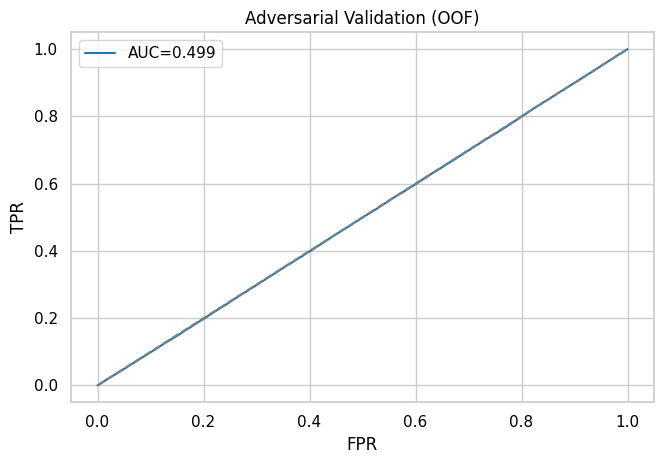

In [20]:
common = [c for c in cols if c in test.columns]
num_common = [c for c in common if c in num_cols]
cat_common = [c for c in common if c in cat_cols and train[c].nunique() <= 30]

if len(num_common) + len(cat_common) < 2:
    print("[ADV] Skipped: insufficient common columns.")
else:
    Xtr_num = train[num_common].apply(pd.to_numeric, errors="coerce").fillna(0)
    Xte_num = test[num_common].apply(pd.to_numeric, errors="coerce").fillna(0)

    Xtr_cat = pd.get_dummies(train[cat_common].astype("object").fillna("__NA__"), drop_first=False)
    Xte_cat = pd.get_dummies(test[cat_common].astype("object").fillna("__NA__"), drop_first=False)

    Xtr_adv, Xte_adv = Xtr_num.join(Xtr_cat), Xte_num.join(Xte_cat)
    Xtr_adv, Xte_adv = Xtr_adv.align(Xte_adv, join="outer", axis=1, fill_value=0)

    Xa = pd.concat([Xtr_adv, Xte_adv], axis=0).reset_index(drop=True).astype("float32")
    ya = np.r_[np.zeros(len(Xtr_adv)), np.ones(len(Xte_adv))].astype(int)

    MAX_ADV = 300_000
    if len(Xa) > MAX_ADV:
        rng = np.random.default_rng(SEED)
        tr_idx = rng.choice(len(Xtr_adv), MAX_ADV//2, replace=False)
        te_idx = rng.choice(len(Xte_adv), MAX_ADV//2, replace=False)
        Xa = pd.concat([Xtr_adv.iloc[tr_idx], Xte_adv.iloc[te_idx]], axis=0).astype("float32")
        ya = np.r_[np.zeros(len(tr_idx)), np.ones(len(te_idx))].astype(int)

    oof_adv = np.zeros(len(Xa))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    for fold, (tr_idx, va_idx) in enumerate(cv.split(Xa, ya), 1):
        clf = LogisticRegression(max_iter=300)
        clf.fit(Xa.iloc[tr_idx], ya[tr_idx])
        oof_adv[va_idx] = clf.predict_proba(Xa.iloc[va_idx])[:, 1]
        print(f"[ADV][fold {fold}] done")

    av_auc = roc_auc_score(ya, oof_adv)
    print(f"[ADV] OOF AUC = {av_auc:.3f} (≈0.5 → low shift)")

    fpr, tpr, _ = roc_curve(ya, oof_adv)
    plt.figure(figsize=(6.8, 4.8))
    plt.plot(fpr, tpr, label=f"AUC={av_auc:.3f}", color=BRAND["blue"])
    plt.plot([0,1],[0,1],"--",c="gray")
    plt.title("Adversarial Validation (OOF)")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.tight_layout()
    savefig_mpl("adv_validation")
    plt.show()


<div style="
    padding:22px 24px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid rgba(148,163,184,0.35);
    line-height:1.6;
    margin-top:24px;
    margin-bottom:24px;
">

<h2 style="margin:0 0 14px 0; font-weight:800; font-size:22px;">
Conclusion (EDA)
</h2>

<h3 style="margin:0 0 10px 0; font-weight:700; font-size:18px;">
Key Insights
</h3>

<ul style="margin-top:6px; padding-left:22px;">
  <li>A small subset of features dominates the predictive signal (see the unified ranking table).</li>
  <li>Numeric predictors show stable, mostly monotonic trends (validated by bootstrap Spearman and quantile profiles).</li>
  <li>Categorical predictors — especially OOF target-rate encodings — provide strong incremental lift.</li>
  <li>Train–test drift is minimal overall (PSI / KS / JS + adversarial AUC ≈ 0.50).</li>
  <li>The 5-fold OOF logistic model gives a calibrated, interpretable baseline with clear gain / capture curves.</li>
</ul>

<h3 style="margin:18px 0 10px 0; font-weight:700; font-size:18px;">
Modeling Implications
</h3>

<ul style="margin-top:6px; padding-left:22px;">
  <li>Use the top-ranked features as the core input space for tree-based models (LGBM, CatBoost, XGB).</li>
  <li>Apply regularized target encoding for categorical predictors, especially high-cardinality ones.</li>
  <li>Keep stratified CV, early stopping, and cost-aware thresholds when moving from EDA to production modeling.</li>
  <li>Leverage the exported JSON / CSV artifacts to monitor drift, feature stability, and baseline performance over time.</li>
</ul>

</div>


<div style="
    padding:22px 24px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid rgba(148,163,184,0.35);
    line-height:1.6;
    margin-top:24px;
    margin-bottom:24px;
">

<h2 style="margin:0 0 14px 0; font-weight:800; font-size:22px;">
Advanced Modeling &amp; Stacked Ensemble (XGB + LGBM + Meta)
</h2>

<ul style="margin-top:8px; padding-left:22px;">
  <li>Feature engineering for gradient boosting (winsorization, ratios, logs, smoothed TE, numeric binning, deviation features).</li>
  <li>Adversarial re-weighting to reduce subtle train–test mismatch before fitting boosted trees.</li>
  <li>Global XGBoost CV across multiple depth / leaf / learning-rate configurations.</li>
  <li>Stacked base models: several tuned XGB configurations plus one robust LGBM baseline.</li>
  <li>Meta-learners: Logistic Regression + shallow XGB trained on base-model OOF predictions.</li>
  <li>Final blended submission and a diagnostics JSON file for downstream analysis and future iterations.</li>
</ul>

</div>


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Advanced Modeling & Stacked Ensemble 
</h2>

</div>


In [21]:
SEED = 42
np.random.seed(SEED)

CFG = dict(
    NFOLDS=7,
    TE_FOLDS=7,
    Q_WINS=(0.005, 0.995),
    TE_M=80.0,
    TE_NOISE=1e-3,
    PAIRS_MAX=8,
    PAIRS_CARD_MAX=40,
    NUMBIN_TOPK=6,
    NUMBIN_Q=10,
    DEV_TOP_CATS=6,
    DEV_TOP_NUMS=8,
    USE_ADV_WEIGHT=True,
    ADV_SAMPLE=400_000,
    ADV_CLIP=(0.2, 5.0),
    ESR=200,
    ROUND_MARGIN=25,
    TOP_K_STACK=3,
)

KAGGLE = os.path.exists("/kaggle/input")
OUT_DIR = "/kaggle/working" if KAGGLE else "."
os.makedirs(OUT_DIR, exist_ok=True)

print(f"[MODEL] train={train.shape} test={test.shape} | target={TARGET} | id={ID_COL}")


[MODEL] train=(593994, 13) test=(254569, 12) | target=loan_paid_back | id=id


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Helper functions (modeling) 
</h2>

</div>


In [22]:
def split_cols(df: pd.DataFrame, drop_cols):
    cols = [c for c in df.columns if c not in drop_cols]
    cat = [c for c in cols if str(df[c].dtype) == "category"]
    num = [c for c in cols if c not in cat]
    return cols, cat, num


def auto_cast_categoricals(
    train: pd.DataFrame,
    test: pd.DataFrame,
    drop_cols,
    max_unique: int = 80,
    max_ratio: float = 0.01,
):
    train = train.copy()
    test = test.copy()
    n = len(train)
    for c in train.columns:
        if c in drop_cols:
            continue
        s = train[c]
        if s.dtype == "object" or str(s.dtype) == "bool" or pd.api.types.is_bool_dtype(s):
            train[c] = s.astype("category")
            if c in test.columns:
                test[c] = test[c].astype("category")
        elif pd.api.types.is_integer_dtype(s) or pd.api.types.is_float_dtype(s):
            nunq = int(s.nunique(dropna=True))
            if (nunq <= max_unique) or (nunq / max(1, n) <= max_ratio):
                train[c] = pd.Categorical(s)
                if c in test.columns:
                    test[c] = pd.Categorical(test[c])
    return train, test


def rare_bucket(series: pd.Series, min_count: int = 50) -> pd.Categorical:
    vc = series.value_counts()
    rare = vc[vc < min_count].index
    s = series.astype("object").copy()
    s[s.isin(rare)] = "__other__"
    return pd.Categorical(s)


def winsorize(df: pd.DataFrame, cols, q_low=0.005, q_high=0.995) -> pd.DataFrame:
    df = df.copy()
    if not cols:
        return df
    lo = df[cols].quantile(q_low)
    hi = df[cols].quantile(q_high)
    for c in cols:
        df[c] = df[c].clip(lo[c], hi[c])
    return df


def add_ratios_and_transforms(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    if {"loan_amount", "annual_income"}.issubset(out.columns):
        denom = out["annual_income"].replace(0, np.nan).astype("float32")
        out["loan_to_income"] = (
            out["loan_amount"].astype("float32") / denom
        ).fillna(0.0).astype("float32")

    if {"debt_to_income_ratio", "interest_rate"}.issubset(out.columns):
        out["dti_x_rate"] = (
            out["debt_to_income_ratio"].astype("float32")
            * out["interest_rate"].astype("float32")
        )

    if "annual_income" in out.columns:
        out["log_annual_income"] = np.log1p(
            out["annual_income"].astype("float32").clip(lower=0)
        ).astype("float32")

    if "loan_amount" in out.columns:
        out["log_loan_amount"] = np.log1p(
            out["loan_amount"].astype("float32").clip(lower=0)
        ).astype("float32")

    if "credit_score" in out.columns:
        cs = out["credit_score"].astype("float32")
        out["credit_score_sqrt"] = np.sqrt(cs.clip(lower=0)).astype("float32")

    if "interest_rate" in out.columns:
        ir = out["interest_rate"].astype("float32")
        out["interest_rate_sq"] = (ir * ir).astype("float32")

    return out


In [23]:
# Derive subgrade from grade_subgrade
if "grade_subgrade" in train.columns:
    train["subgrade"] = train["grade_subgrade"].astype(str).str[1:]
    test["subgrade"] = test["grade_subgrade"].astype(str).str[1:]
    for df_ in (train, test):
        try:
            df_["subgrade"] = df_["subgrade"].astype("int16")
        except Exception:
            pass

# Pre-casting
drop_base = [TARGET, ID_COL]
train_cast, test_cast = auto_cast_categoricals(train, test, drop_cols=drop_base)

COLS0, CAT0, NUM0 = split_cols(train_cast, [TARGET, ID_COL])

num_raw = [n for n in NUM0 if pd.api.types.is_numeric_dtype(train_cast[n])]
train_cast[num_raw] = winsorize(train_cast, num_raw, *CFG["Q_WINS"])[num_raw]
test_cast[num_raw] = winsorize(test_cast, num_raw, *CFG["Q_WINS"])[num_raw]

train_cast = add_ratios_and_transforms(train_cast)
test_cast = add_ratios_and_transforms(test_cast)


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Target Encoding (OOF)
</h2>

</div>


In [24]:
def kfold_te(
    tr: pd.DataFrame,
    te: pd.DataFrame,
    cat_cols,
    ycol: str,
    n_splits: int = 7,
    seed: int = 42,
    m: float = 80.0,
    noise: float = 1e-3,
    do_pairs: bool = True,
    max_pairs: int = 8,
    max_cat_pair_card: int = 40,
):
    tr = tr.copy()
    te = te.copy()
    prior = float(tr[ycol].mean())
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    avail = []
    for c in cat_cols:
        if c not in tr.columns:
            continue
        tr[c] = rare_bucket(tr[c], min_count=50)
        if c in te.columns:
            cats = list(tr[c].cat.categories)
            if "__other__" not in cats:
                cats.append("__other__")
            te[c] = pd.Categorical(
                te[c].astype("object").where(te[c].isin(tr[c].cat.categories), "__other__"),
                categories=cats,
            )
        avail.append(c)

    def _smooth(su: pd.Series, ct: pd.Series) -> pd.Series:
        return (su + m * prior) / (ct + m)

    for c in avail:
        oof = np.zeros(len(tr), dtype=np.float32)
        for tr_idx, va_idx in skf.split(tr, tr[ycol].astype(int)):
            g = tr.iloc[tr_idx].groupby(c)[ycol].agg(["sum", "count"]).astype("float32")
            mu = _smooth(g["sum"], g["count"])
            oof[va_idx] = (
                tr.iloc[va_idx][c]
                .map(mu)
                .astype("float32")
                .fillna(prior)
                .values
            )
        oof += np.random.normal(0.0, noise, size=oof.shape).astype("float32")
        tr[f"te_{c}"] = oof

        g_all = tr.groupby(c)[ycol].agg(["sum", "count"]).astype("float32")
        mu_all = _smooth(g_all["sum"], g_all["count"])
        te[f"te_{c}"] = (
            te[c]
            .map(mu_all)
            .astype("float32")
            .fillna(prior)
            .values
        )

    if do_pairs and len(avail) > 1:
        ranked = sorted(avail, key=lambda col: tr[col].nunique())
        pairs = []
        for i in range(len(ranked) - 1):
            a, b = ranked[i], ranked[i + 1]
            if tr[a].nunique() <= max_cat_pair_card and tr[b].nunique() <= max_cat_pair_card:
                pairs.append((a, b))
            if len(pairs) >= max_pairs:
                break

        for a, b in pairs:
            key_tr = tr[a].astype(str) + "§" + tr[b].astype(str)
            oof = np.zeros(len(tr), dtype=np.float32)
            for tr_idx, va_idx in skf.split(tr, tr[ycol].astype(int)):
                grp = (
                    pd.DataFrame({"k": key_tr.iloc[tr_idx], "y": tr.iloc[tr_idx][ycol]})
                    .groupby("k")["y"]
                    .agg(["sum", "count"])
                    .astype("float32")
                )
                mu = _smooth(grp["sum"], grp["count"])
                comb_va = (
                    tr[a].astype(str).iloc[va_idx] + "§" +
                    tr[b].astype(str).iloc[va_idx]
                )
                oof[va_idx] = (
                    comb_va.map(mu)
                    .astype("float32")
                    .fillna(prior)
                    .values
                )
            oof += np.random.normal(0.0, noise, size=oof.shape).astype("float32")
            tr[f"te_{a}__{b}"] = oof

            grp_all = (
                pd.DataFrame({"k": key_tr, "y": tr[ycol]})
                .groupby("k")["y"]
                .agg(["sum", "count"])
                .astype("float32")
            )
            mu_all = _smooth(grp_all["sum"], grp_all["count"])
            key_te = te[a].astype(str) + "§" + te[b].astype(str)
            te[f"te_{a}__{b}"] = (
                key_te.map(mu_all)
                .astype("float32")
                .fillna(prior)
                .values
            )

    return tr, te


In [25]:
def add_freq(tr: pd.DataFrame, te: pd.DataFrame, cat_cols):
    tr = tr.copy()
    te = te.copy()
    for c in cat_cols:
        if c not in tr.columns:
            continue
        vc = tr[c].value_counts()
        tr[f"{c}_freq"] = tr[c].map(vc).astype("float32")
        if c in te.columns:
            te[f"{c}_freq"] = te[c].map(vc).astype("float32").fillna(vc.mean())
    return tr, te


def numbin_te(
    tr: pd.DataFrame,
    te: pd.DataFrame,
    ycol: str,
    num_cols,
    q: int = 10,
    topk: int = 6,
    m: float = 60.0,
    noise: float = 1e-3,
):
    tr = tr.copy()
    te = te.copy()
    ranks = sorted(
        [(c, float(tr[c].var(skipna=True))) for c in num_cols if pd.api.types.is_numeric_dtype(tr[c])],
        key=lambda t: -t[1],
    )
    pick = [c for c, _ in ranks[:topk]]
    if not pick:
        return tr, te

    skf = StratifiedKFold(n_splits=CFG["TE_FOLDS"], shuffle=True, random_state=SEED)
    prior = float(tr[ycol].mean())

    def _smooth(su: pd.Series, ct: pd.Series) -> pd.Series:
        return (su + m * prior) / (ct + m)

    for c in pick:
        try:
            bins, edges = pd.qcut(
                tr[c],
                q=q,
                labels=False,
                retbins=True,
                duplicates="drop",
            )
        except Exception:
            continue

        bin_col = f"{c}_bin{q}"
        tr[bin_col] = bins.astype("int16")
        te[bin_col] = pd.cut(
            te[c],
            bins=edges,
            labels=False,
            include_lowest=True,
        ).astype("float32")

        oof = np.zeros(len(tr), dtype=np.float32)
        for tr_idx, va_idx in skf.split(tr, tr[ycol].astype(int)):
            g = tr.iloc[tr_idx].groupby(bin_col)[ycol].agg(["sum", "count"]).astype("float32")
            mu = _smooth(g["sum"], g["count"])
            oof[va_idx] = (
                tr.iloc[va_idx][bin_col]
                .map(mu)
                .astype("float32")
                .fillna(prior)
                .values
            )
        oof += np.random.normal(0.0, noise, size=oof.shape).astype("float32")
        tr[f"te_{bin_col}"] = oof

        g_all = tr.groupby(bin_col)[ycol].agg(["sum", "count"]).astype("float32")
        mu_all = _smooth(g_all["sum"], g_all["count"])
        te[f"te_{bin_col}"] = (
            te[bin_col]
            .map(mu_all)
            .astype("float32")
            .fillna(prior)
            .values
        )

    return tr, te


In [26]:
def num_cat_dev(
    tr: pd.DataFrame,
    te: pd.DataFrame,
    num_cols,
    cat_cols,
    top_cats: int = 6,
    top_nums: int = 8,
):
    tr_out = tr.copy()
    te_out = te.copy()
    num_cols = [n for n in num_cols if n in tr_out.columns]

    for n in num_cols:
        if not pd.api.types.is_numeric_dtype(tr_out[n]):
            tr_out[n] = pd.to_numeric(tr_out[n], errors="coerce")
        if n in te_out.columns and not pd.api.types.is_numeric_dtype(te_out[n]):
            te_out[n] = pd.to_numeric(te_out[n], errors="coerce")
        tr_out[n] = tr_out[n].astype("float32")
        if n in te_out.columns:
            te_out[n] = te_out[n].astype("float32")

    safe_cats = [c for c in cat_cols if c in tr_out.columns and str(tr_out[c].dtype) == "category"]
    imp_cats = sorted(safe_cats, key=lambda c: tr_out[c].nunique())[:top_cats]
    use_nums = num_cols[:top_nums]

    for c in imp_cats:
        grp_mean = tr_out.groupby(c)[use_nums].mean()
        gmean = {n: float(tr_out[n].mean()) for n in use_nums}
        for n in use_nums:
            tr_map = tr_out[c].map(grp_mean[n]).astype("float32").fillna(gmean[n])
            te_map = te_out[c].map(grp_mean[n]).astype("float32").fillna(gmean[n])
            tr_out[f"{c}_x_{n}_dev"] = (tr_out[n] - tr_map).astype("float32")
            te_out[f"{c}_x_{n}_dev"] = (te_out[n] - te_map).astype("float32")

    return tr_out, te_out


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Build feature matrix
</h2>

</div>


In [27]:
COLS0, CAT0, NUM0 = split_cols(train_cast, [TARGET, ID_COL])

num_raw = [n for n in NUM0 if pd.api.types.is_numeric_dtype(train_cast[n])]
train_fe, test_fe = train_cast.copy(), test_cast.copy()

train_fe[num_raw] = winsorize(train_fe, num_raw, *CFG["Q_WINS"])[num_raw]
test_fe[num_raw] = winsorize(test_fe, num_raw, *CFG["Q_WINS"])[num_raw]

train_fe = add_ratios_and_transforms(train_fe)
test_fe = add_ratios_and_transforms(test_fe)

train_fe, test_fe = kfold_te(
    train_fe,
    test_fe,
    CAT0,
    TARGET,
    n_splits=CFG["TE_FOLDS"],
    seed=SEED,
    m=CFG["TE_M"],
    noise=CFG["TE_NOISE"],
    do_pairs=True,
    max_pairs=CFG["PAIRS_MAX"],
    max_cat_pair_card=CFG["PAIRS_CARD_MAX"],
)

COLS1, CAT1, NUM1 = split_cols(train_fe, [TARGET, ID_COL])
train_fe, test_fe = add_freq(train_fe, test_fe, CAT1)
COLS2, CAT2, NUM2 = split_cols(train_fe, [TARGET, ID_COL])

train_fe, test_fe = numbin_te(
    train_fe,
    test_fe,
    TARGET,
    NUM2,
    q=CFG["NUMBIN_Q"],
    topk=CFG["NUMBIN_TOPK"],
    m=60.0,
    noise=CFG["TE_NOISE"],
)

COLS3, CAT3, NUM3 = split_cols(train_fe, [TARGET, ID_COL])

train_fe, test_fe = num_cat_dev(
    train_fe,
    test_fe,
    NUM3,
    CAT3,
    top_cats=CFG["DEV_TOP_CATS"],
    top_nums=CFG["DEV_TOP_NUMS"],
)

for c in CAT3:
    train_fe[c] = train_fe[c].astype("category")
    if c in test_fe.columns:
        test_fe[c] = test_fe[c].astype("category")


In [28]:
X = train_fe.drop(columns=[TARGET, ID_COL], errors="ignore").copy()
y = train_fe[TARGET].astype("int8").values
X_test = test_fe.copy()

raw_cat_cols = [c for c in X.columns if str(train_fe[c].dtype) == "category"]
if raw_cat_cols:
    X.drop(columns=raw_cat_cols, inplace=True)
    X_test.drop(columns=raw_cat_cols, inplace=True)

for col in X.columns:
    if col not in X_test.columns:
        X_test[col] = 0.0
X_test = X_test[X.columns]
assert list(X_test.columns) == list(X.columns)


In [29]:
def to_numeric_features(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame(index=df.index)
    for c in df.columns:
        s = df[c]
        if str(s.dtype) == "category":
            out[c] = s.cat.codes.astype("int32")
        elif pd.api.types.is_bool_dtype(s):
            out[c] = s.astype("int8")
        elif pd.api.types.is_integer_dtype(s):
            out[c] = s.astype("int32")
        elif pd.api.types.is_float_dtype(s):
            out[c] = s.astype("float32")
        else:
            out[c] = pd.to_numeric(s, errors="coerce").astype("float32")
    nunq = out.nunique(dropna=False)
    keep = nunq[nunq > 1].index
    if len(keep) != out.shape[1]:
        out = out[keep]
    out = out.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return out


Xn = to_numeric_features(X)
Xn_test = to_numeric_features(X_test)
assert list(Xn.columns) == list(Xn_test.columns)

te_count = sum(c.startswith("te_") for c in Xn.columns)
print(f"[MATRIX] Xn={Xn.shape}, Xn_test={Xn_test.shape} | features={len(Xn.columns)}")
print(f"[TE feats] count = {te_count}")


[MATRIX] Xn=(593994, 94), Xn_test=(254569, 94) | features=94
[TE feats] count = 22


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
XGB params + GPU probe
</h2>

</div>


In [30]:
base_params = dict(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    max_bin=512,
    subsample=0.90,
    colsample_bytree=0.80,
    colsample_bylevel=0.90,
    learning_rate=0.025,
    reg_lambda=2.0,
    reg_alpha=0.20,
)

use_params = dict(base_params)
xgb_ver = tuple(int(v) for v in xgb.__version__.split(".")[:2])
print(f"[XGB] version={xgb.__version__}")

pos = float(y.sum())
neg = float(len(y) - y.sum())
if pos < neg:
    use_params["scale_pos_weight"] = neg / max(1.0, pos)

try:
    d_probe = xgb.DMatrix(Xn.head(2000), label=y[:2000])
    probe_params = dict(use_params)
    if xgb_ver[0] >= 2:
        probe_params["device"] = "cuda"
        probe_params["tree_method"] = "hist"
    else:
        probe_params["tree_method"] = "gpu_hist"
    _ = xgb.train(probe_params, d_probe, num_boost_round=1)
    if xgb_ver[0] >= 2:
        use_params["device"] = "cuda"
        use_params["tree_method"] = "hist"
        print("[INFO] Using GPU via device='cuda' + tree_method='hist'")
    else:
        use_params["tree_method"] = "gpu_hist"
        print("[INFO] Using GPU via tree_method='gpu_hist'")
except Exception as e:
    use_params["tree_method"] = "hist"
    use_params.pop("device", None)
    print("[INFO] Using CPU (tree_method='hist'); GPU probe failed with:")
    print("      ", repr(e))


[XGB] version=2.0.3
[INFO] Using GPU via device='cuda' + tree_method='hist'


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Adversarial re-weighting
</h2>

</div>


In [31]:
def adversarial_weights(
    X_all: pd.DataFrame,
    X_te: pd.DataFrame,
    tree_method: str,
    device: str | None,
    sample: int = 400_000,
    clip: tuple[float, float] = (0.2, 5.0),
    seed: int = 42,
) -> np.ndarray:
    n = len(X_all)
    n_sample = min(sample, n)
    rs = np.random.RandomState(seed)

    idx = rs.choice(n, size=n_sample, replace=False)
    A = X_all.iloc[idx].copy()
    yA = np.ones(len(A), dtype=np.int8)

    B = X_te.sample(n=min(sample // 2, len(X_te)), random_state=seed).copy()
    yB = np.zeros(len(B), dtype=np.int8)

    Z = pd.concat([A, B], axis=0).reset_index(drop=True)
    yZ = np.concatenate([yA, yB], axis=0)

    dZ = xgb.DMatrix(Z, label=yZ)

    adv_params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": tree_method,
        "learning_rate": 0.08,
        "max_depth": 6,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "reg_lambda": 1.0,
        "reg_alpha": 0.0,
        "verbosity": 0,
        "seed": seed,
    }
    if device is not None:
        adv_params["device"] = device

    booster = xgb.train(adv_params, dZ, num_boost_round=300)

    p_train = booster.predict(xgb.DMatrix(X_all))
    eps = 1e-6

    w = (1.0 - p_train) / np.maximum(p_train, eps)

    lo, hi = clip
    w = np.clip(w, lo, hi).astype("float32")

    mean_w = float(w.mean())
    if mean_w > 0:
        w = (w / mean_w).astype("float32")

    return w


train_weights = None
if CFG["USE_ADV_WEIGHT"]:
    try:
        tm = use_params.get("tree_method", "hist")
        dev = use_params.get("device", None)
        train_weights = adversarial_weights(
            X_all=Xn,
            X_te=Xn_test,
            tree_method=tm,
            device=dev,
            sample=CFG["ADV_SAMPLE"],
            clip=CFG["ADV_CLIP"],
            seed=SEED,
        )
        print(
            f"[ADV] weights: min={train_weights.min():.3f}, "
            f"max={train_weights.max():.3f}, mean={train_weights.mean():.3f}"
        )
    except Exception as e:
        print("[ADV] skipped:", str(e))
        train_weights = None


[ADV] weights: min=1.000, max=1.000, mean=1.000


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Global CV (xgb.cv) search
</h2>

</div>


In [32]:
dtrain_all = xgb.DMatrix(
    Xn,
    label=y,
    weight=(None if train_weights is None else train_weights),
)

cv_configs = [
    ("d7_mc16_eta025", {"max_depth": 7, "min_child_weight": 16, "learning_rate": 0.025}),
    ("d7_mc16_eta020", {"max_depth": 7, "min_child_weight": 16, "learning_rate": 0.020}),
    ("d7_mc20_eta020", {"max_depth": 7, "min_child_weight": 20, "learning_rate": 0.020}),
    ("d8_mc20_eta020", {"max_depth": 8, "min_child_weight": 20, "learning_rate": 0.020}),
    ("leaf64_eta020",  {"max_depth": 0, "max_leaves": 64, "min_child_weight": 18, "learning_rate": 0.020}),
    ("leaf96_eta018",  {"max_depth": 0, "max_leaves": 96, "min_child_weight": 20, "learning_rate": 0.018}),
]

cv_results = []
best_auc = -1.0
best_round = 600
best_name = None
best_extra = None

for name, extra in cv_configs:
    params = {**use_params, **extra, "seed": SEED}
    cv_res = xgb.cv(
        params=params,
        dtrain=dtrain_all,
        nfold=CFG["NFOLDS"],
        stratified=True,
        num_boost_round=20_000,
        early_stopping_rounds=CFG["ESR"],
        verbose_eval=False,
        seed=SEED,
    )
    br = int(cv_res["test-auc-mean"].idxmax())
    ba = float(cv_res["test-auc-mean"].max())
    print(f"[CV] {name} {extra} -> AUC={ba:.6f} @ {br}")

    cv_results.append({"name": name, "best_auc": ba, "best_round": br})

    if ba > best_auc:
        best_auc = ba
        best_round = br
        best_name = name
        best_extra = extra

    gc.collect()

final_n_estimators = int(best_round) + CFG["ROUND_MARGIN"]
print(
    f"[BEST] {best_name} | AUC={best_auc:.6f} | "
    f"rounds={best_round} -> final_n_estimators={final_n_estimators}"
)


[CV] d7_mc16_eta025 {'max_depth': 7, 'min_child_weight': 16, 'learning_rate': 0.025} -> AUC=0.925266 @ 661
[CV] d7_mc16_eta020 {'max_depth': 7, 'min_child_weight': 16, 'learning_rate': 0.02} -> AUC=0.925304 @ 925
[CV] d7_mc20_eta020 {'max_depth': 7, 'min_child_weight': 20, 'learning_rate': 0.02} -> AUC=0.925299 @ 925
[CV] d8_mc20_eta020 {'max_depth': 8, 'min_child_weight': 20, 'learning_rate': 0.02} -> AUC=0.925208 @ 860
[CV] leaf64_eta020 {'max_depth': 0, 'max_leaves': 64, 'min_child_weight': 18, 'learning_rate': 0.02} -> AUC=0.925353 @ 912
[CV] leaf96_eta018 {'max_depth': 0, 'max_leaves': 96, 'min_child_weight': 20, 'learning_rate': 0.018} -> AUC=0.925302 @ 809
[BEST] leaf64_eta020 | AUC=0.925353 | rounds=912 -> final_n_estimators=937


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
XGB OOF helper
</h2>

</div>


In [33]:
def fit_xgb_oof_single(
    name: str,
    params: dict,
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_te: pd.DataFrame,
    nfolds: int = 7,
    seeds: tuple = (42, 2027),
    n_estimators: int = 1000,
    sample_weight: np.ndarray | None = None,
):
    folds = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=SEED)
    n = len(X_train)
    oof = np.zeros(n, dtype=np.float32)
    preds = np.zeros(len(X_te), dtype=np.float32)

    print("\n" + "=" * 70)
    print(f"[STACK] Training base model: {name}")
    print(f"        n_estimators={n_estimators}")
    print("=" * 70)

    for sd in seeds:
        fold_preds = np.zeros(len(X_te), dtype=np.float32)
        for fold_id, (tr_idx, va_idx) in enumerate(folds.split(X_train, y_train), start=1):
            X_tr = X_train.iloc[tr_idx]
            X_va = X_train.iloc[va_idx]
            y_tr = y_train[tr_idx]
            y_va = y_train[va_idx]

            if sample_weight is not None:
                w_tr = sample_weight[tr_idx]
            else:
                w_tr = None

            clf = XGBClassifier(
                **params,
                n_estimators=int(n_estimators),
                n_jobs=-1,
                random_state=sd,
            )

            if w_tr is None:
                clf.fit(X_tr, y_tr, verbose=False)
            else:
                clf.fit(X_tr, y_tr, sample_weight=w_tr, verbose=False)

            oof[va_idx] += clf.predict_proba(X_va)[:, 1].astype("float32")
            fold_preds += clf.predict_proba(X_te)[:, 1].astype("float32") / nfolds

            gc.collect()

        preds += fold_preds / len(seeds)

    oof /= len(seeds)
    auc = roc_auc_score(y_train, oof)
    print(f"[STACK] {name} OOF AUC={auc:.6f}")
    return oof, preds, auc


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
LGBM OOF helper
</h2>

</div>


In [34]:
def fit_lgb_oof(
    name: str,
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_te: pd.DataFrame,
    nfolds: int = 7,
    seeds: tuple = (42, 2027),
    sample_weight: np.ndarray | None = None,
):
    folds = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=SEED)
    n = len(X_train)
    oof = np.zeros(n, dtype=np.float32)
    preds = np.zeros(len(X_te), dtype=np.float32)

    base_params = dict(
        objective="binary",
        metric="auc",
        learning_rate=0.03,
        num_leaves=63,
        max_depth=-1,
        min_data_in_leaf=60,
        feature_fraction=0.85,
        bagging_fraction=0.85,
        bagging_freq=1,
        lambda_l1=0.1,
        lambda_l2=1.0,
        verbose=-1,
        n_estimators=1200,
    )

    try:
        clf_probe = lgb.LGBMClassifier(**base_params, device_type="gpu")
        clf_probe.fit(X_train.head(2000), y_train[:2000])
        base_params["device_type"] = "gpu"
        print("[LGBM] Using GPU")
    except Exception:
        print("[LGBM] Using CPU")

    print("\n" + "=" * 70)
    print(f"[STACK] Training base model: {name} (LGBM)")
    print("=" * 70)

    for sd in seeds:
        fold_preds = np.zeros(len(X_te), dtype=np.float32)
        for fold_id, (tr_idx, va_idx) in enumerate(folds.split(X_train, y_train), start=1):
            X_tr = X_train.iloc[tr_idx]
            X_va = X_train.iloc[va_idx]
            y_tr = y_train[tr_idx]
            y_va = y_train[va_idx]

            if sample_weight is not None:
                w_tr = sample_weight[tr_idx]
            else:
                w_tr = None

            clf = lgb.LGBMClassifier(**base_params, random_state=sd)

            if w_tr is None:
                clf.fit(X_tr, y_tr)
            else:
                clf.fit(X_tr, y_tr, sample_weight=w_tr)

            oof[va_idx] += clf.predict_proba(X_va)[:, 1].astype("float32")
            fold_preds += clf.predict_proba(X_te)[:, 1].astype("float32") / nfolds

            gc.collect()

        preds += fold_preds / len(seeds)

    oof /= len(seeds)
    auc = roc_auc_score(y_train, oof)
    print(f"[STACK] {name} OOF AUC={auc:.6f}")
    return oof, preds, auc


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Train base XGB configs + LGBM
</h2>

</div>


In [35]:
cv_results_sorted = sorted(cv_results, key=lambda d: d["best_auc"], reverse=True)
top_configs = cv_results_sorted[: CFG["TOP_K_STACK"]]

print("\n[STACK] Using top configs for stacking:")
for cfg in top_configs:
    print(f"   {cfg['name']}: AUC={cfg['best_auc']:.6f} @ {cfg['best_round']}")

base_oof = {}
base_test = {}
base_info = []

for cfg in top_configs:
    name = cfg["name"]
    extra = next(e for (n, e) in cv_configs if n == name)
    n_estimators = int(cfg["best_round"]) + CFG["ROUND_MARGIN"]
    params = {**use_params, **extra}

    oof_, pred_, auc_ = fit_xgb_oof_single(
        name=name,
        params=params,
        X_train=Xn,
        y_train=y,
        X_te=Xn_test,
        nfolds=CFG["NFOLDS"],
        seeds=(42, 2027),
        n_estimators=n_estimators,
        sample_weight=train_weights,
    )

    base_oof[name] = oof_
    base_test[name] = pred_
    base_info.append({"name": name, "oof_auc": float(auc_), "n_estimators": n_estimators})

# LGBM as extra base model
lgb_name = "lgbm_main"
try:
    oof_lgb, pred_lgb, auc_lgb = fit_lgb_oof(
        name=lgb_name,
        X_train=Xn,
        y_train=y,
        X_te=Xn_test,
        nfolds=CFG["NFOLDS"],
        seeds=(42, 2027),
        sample_weight=train_weights,
    )
    base_oof[lgb_name] = oof_lgb
    base_test[lgb_name] = pred_lgb
    base_info.append({"name": lgb_name, "oof_auc": float(auc_lgb), "n_estimators": 1200})
except Exception as e:
    print("[LGBM] Skipped due to error:", str(e))

print("\n[STACK] Base models used:", list(base_oof.keys()))



[STACK] Using top configs for stacking:
   leaf64_eta020: AUC=0.925353 @ 912
   d7_mc16_eta020: AUC=0.925304 @ 925
   leaf96_eta018: AUC=0.925302 @ 809

[STACK] Training base model: leaf64_eta020
        n_estimators=937
[STACK] leaf64_eta020 OOF AUC=0.925397

[STACK] Training base model: d7_mc16_eta020
        n_estimators=950
[STACK] d7_mc16_eta020 OOF AUC=0.925372

[STACK] Training base model: leaf96_eta018
        n_estimators=834
[STACK] leaf96_eta018 OOF AUC=0.925325


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LGBM] Using GPU

[STACK] Training base model: lgbm_main (LGBM)
[STACK] lgbm_main OOF AUC=0.924959

[STACK] Base models used: ['leaf64_eta020', 'd7_mc16_eta020', 'leaf96_eta018', 'lgbm_main']


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Meta features: raw + ranks + stats
</h2>

</div>


In [36]:
oof_stack = pd.DataFrame(base_oof)
test_stack = pd.DataFrame(base_test)

print("[STACK] oof_stack shape:", oof_stack.shape)
print("[STACK] test_stack shape:", test_stack.shape)

rank_oof = oof_stack.rank(axis=1, method="average") / (len(base_oof) + 1.0)
rank_test = test_stack.rank(axis=1, method="average") / (len(base_test) + 1.0)
rank_oof.columns = [c + "_rank" for c in rank_oof.columns]
rank_test.columns = [c + "_rank" for c in rank_test.columns]

meta_stats_oof = pd.DataFrame({
    "base_mean": oof_stack.mean(axis=1),
    "base_std": oof_stack.std(axis=1),
    "base_min": oof_stack.min(axis=1),
    "base_max": oof_stack.max(axis=1),
})
meta_stats_test = pd.DataFrame({
    "base_mean": test_stack.mean(axis=1),
    "base_std": test_stack.std(axis=1),
    "base_min": test_stack.min(axis=1),
    "base_max": test_stack.max(axis=1),
})

meta_oof = pd.concat([oof_stack, rank_oof, meta_stats_oof], axis=1)
meta_test = pd.concat([test_stack, rank_test, meta_stats_test], axis=1)

print("[STACK] meta features shape (oof): ", meta_oof.shape)
print("[STACK] meta features shape (test):", meta_test.shape)


[STACK] oof_stack shape: (593994, 4)
[STACK] test_stack shape: (254569, 4)
[STACK] meta features shape (oof):  (593994, 12)
[STACK] meta features shape (test): (254569, 12)


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Meta models: LR + XGB
</h2>

</div>


In [37]:
meta_results = {}

lr_meta = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=300,
    n_jobs=-1,
)
lr_meta.fit(meta_oof, y)
meta_pred_lr = lr_meta.predict_proba(meta_oof)[:, 1].astype("float32")
auc_lr = roc_auc_score(y, meta_pred_lr)
meta_results["lr"] = {"auc": float(auc_lr)}
print(f"[META] LogisticRegression stacked OOF AUC={auc_lr:.6f}")

meta_xgb_params = dict(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    max_depth=3,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.0,
)

try:
    if "device" in use_params and use_params["device"] == "cuda":
        meta_xgb_params["device"] = "cuda"
        meta_xgb_params["tree_method"] = "hist"
except Exception:
    pass

meta_xgb = XGBClassifier(
    **meta_xgb_params,
    n_estimators=400,
    n_jobs=-1,
    random_state=SEED,
)
meta_xgb.fit(meta_oof, y)
meta_pred_xgb = meta_xgb.predict_proba(meta_oof)[:, 1].astype("float32")
auc_xgb_meta = roc_auc_score(y, meta_pred_xgb)
meta_results["xgb"] = {"auc": float(auc_xgb_meta)}
print(f"[META] XGB meta stacked OOF AUC={auc_xgb_meta:.6f}")

meta_pred_blend = 0.5 * meta_pred_lr + 0.5 * meta_pred_xgb
auc_blend = roc_auc_score(y, meta_pred_blend)
meta_results["blend"] = {"auc": float(auc_blend)}
print(f"[META] Blended (LR + XGB) stacked OOF AUC={auc_blend:.6f}")

best_meta_name = max(meta_results.keys(), key=lambda k: meta_results[k]["auc"])
best_meta_auc = meta_results[best_meta_name]["auc"]
print(f"[META] Best meta = {best_meta_name} | OOF AUC={best_meta_auc:.6f}")


[META] LogisticRegression stacked OOF AUC=0.925192
[META] XGB meta stacked OOF AUC=0.925863
[META] Blended (LR + XGB) stacked OOF AUC=0.925710
[META] Best meta = xgb | OOF AUC=0.925863


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Final test predictions from meta
</h2>

</div>


In [38]:
test_pred_lr = lr_meta.predict_proba(meta_test)[:, 1].astype("float32")
test_pred_xgb = meta_xgb.predict_proba(meta_test)[:, 1].astype("float32")
test_pred_blend = 0.5 * test_pred_lr + 0.5 * test_pred_xgb

if best_meta_name == "lr":
    final_test_pred = test_pred_lr
elif best_meta_name == "xgb":
    final_test_pred = test_pred_xgb
else:
    final_test_pred = test_pred_blend

best_single = max(base_info, key=lambda d: d["oof_auc"])
best_single_name = best_single["name"]
best_single_oof_auc = best_single["oof_auc"]
best_single_test_pred = base_test[best_single_name]

print(f"Saved best single base model: {best_single_name} | OOF AUC={best_single_oof_auc:.6f}")


Saved best single base model: leaf64_eta020 | OOF AUC=0.925397


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Save submissions
</h2>

</div>


In [39]:
sub_single = pd.DataFrame({ID_COL: test[ID_COL].values, TARGET: best_single_test_pred})
sub_single_path = os.path.join(OUT_DIR, "submission_single_best.csv")
sub_single.to_csv(sub_single_path, index=False)
print("Saved best single submission:", sub_single_path)

sub_meta_lr = pd.DataFrame({ID_COL: test[ID_COL].values, TARGET: test_pred_lr})
sub_meta_lr_path = os.path.join(OUT_DIR, "submission_stacked_lr.csv")
sub_meta_lr.to_csv(sub_meta_lr_path, index=False)
print("Saved stacked LR submission:", sub_meta_lr_path)

sub_meta_xgb = pd.DataFrame({ID_COL: test[ID_COL].values, TARGET: test_pred_xgb})
sub_meta_xgb_path = os.path.join(OUT_DIR, "submission_stacked_xgb.csv")
sub_meta_xgb.to_csv(sub_meta_xgb_path, index=False)
print("Saved stacked XGB submission:", sub_meta_xgb_path)

sub_meta_blend = pd.DataFrame({ID_COL: test[ID_COL].values, TARGET: test_pred_blend})
sub_meta_blend_path = os.path.join(OUT_DIR, "submission_stacked_blend.csv")
sub_meta_blend.to_csv(sub_meta_blend_path, index=False)
print("Saved blended stacked submission:", sub_meta_blend_path)

sub_final = pd.DataFrame({ID_COL: test[ID_COL].values, TARGET: final_test_pred})
sub_final_path = os.path.join(OUT_DIR, "submission.csv")
sub_final.to_csv(sub_final_path, index=False)
print("Saved final submission:", sub_final_path)


Saved best single submission: /kaggle/working/submission_single_best.csv
Saved stacked LR submission: /kaggle/working/submission_stacked_lr.csv
Saved stacked XGB submission: /kaggle/working/submission_stacked_xgb.csv
Saved blended stacked submission: /kaggle/working/submission_stacked_blend.csv
Saved final submission: /kaggle/working/submission.csv


<div style="
    padding:20px 22px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.55;
    margin-top:20px;
    margin-bottom:20px;
">

<h2 style="margin:0 0 12px 0; font-weight:800; font-size:22px;">
Diagnostics JSON
</h2>

</div>


In [40]:
used_gpu = bool(use_params.get("device", None) == "cuda")

diag = {
    "features_total": int(Xn.shape[1]),
    "te_features": int(te_count),
    "xgb_version": xgb.__version__,
    "used_gpu": used_gpu,
    "cv_results": cv_results_sorted,
    "best_cv_auc": float(best_auc),
    "best_cv_name": best_name,
    "best_cv_round": int(best_round),
    "stack_base_models": base_info,
    "best_single_name": best_single_name,
    "best_single_oof_auc": float(best_single_oof_auc),
    "stacked_auc_lr": float(meta_results["lr"]["auc"]),
    "stacked_auc_xgb": float(meta_results["xgb"]["auc"]),
    "stacked_auc_blend": float(meta_results["blend"]["auc"]),
    "best_meta_name": best_meta_name,
    "best_meta_auc": float(best_meta_auc),
}
with open(os.path.join(OUT_DIR, "diag_ensemble.json"), "w") as f:
    json.dump(diag, f, indent=2)
print(json.dumps(diag, indent=2))


{
  "features_total": 94,
  "te_features": 22,
  "xgb_version": "2.0.3",
  "used_gpu": true,
  "cv_results": [
    {
      "name": "leaf64_eta020",
      "best_auc": 0.9253531909139844,
      "best_round": 912
    },
    {
      "name": "d7_mc16_eta020",
      "best_auc": 0.9253039646967484,
      "best_round": 925
    },
    {
      "name": "leaf96_eta018",
      "best_auc": 0.9253018460678114,
      "best_round": 809
    },
    {
      "name": "d7_mc20_eta020",
      "best_auc": 0.9252986846313435,
      "best_round": 925
    },
    {
      "name": "d7_mc16_eta025",
      "best_auc": 0.9252655354122558,
      "best_round": 661
    },
    {
      "name": "d8_mc20_eta020",
      "best_auc": 0.9252084867740192,
      "best_round": 860
    }
  ],
  "best_cv_auc": 0.9253531909139844,
  "best_cv_name": "leaf64_eta020",
  "best_cv_round": 912,
  "stack_base_models": [
    {
      "name": "leaf64_eta020",
      "oof_auc": 0.9253965568130512,
      "n_estimators": 937
    },
    {
      "name

<div style="
    padding:22px 24px;
    background:#1c1f23;
    color:#d7dce2;
    border-radius:12px;
    border:1px solid #2a2e33;
    line-height:1.6;
    margin-top:24px;
    margin-bottom:24px;
">

<h2 style="margin:0 0 14px 0; font-weight:800; font-size:22px;">
Conclusion
</h2>

<h3 style="margin:0 0 10px 0; font-weight:700; font-size:18px;">
Key Insights
</h3>

<ul style="margin-top:6px; padding-left:22px;">
  <li>A compact subset of features carries most of the predictive signal (see the unified ranking and exported top-features table).</li>
  <li>Numeric predictors show stable monotonic behavior, confirmed via bootstrap Spearman and quantile target profiles.</li>
  <li>Categorical predictors — especially smoothed OOF target-rate encodings and pairwise TE — provide strong incremental lift.</li>
  <li>The 5-fold OOF logistic baseline offers an interpretable, well-calibrated reference model with clear gain / capture profiles.</li>
  <li>Gradient-boosted trees and the stacked meta layer (LR + shallow XGB) consistently improve over the baseline in cross-validation.</li>
</ul>

<h3 style="margin:18px 0 10px 0; font-weight:700; font-size:18px;">
Modeling Implications
</h3>

<ul style="margin-top:6px; padding-left:22px;">
  <li>Use the best single XGB configuration as a strong, deployment-friendly default; keep the stacked ensemble as a higher-variance, max-AUC option.</li>
  <li>Leverage regularized target encoding, frequency features, and simple numeric transforms (log / ratios / binning) as a reusable feature toolbox for similar credit-risk problems.</li>
  <li>Keep stratified K-fold CV, early stopping, and adversarial re-weighting in place to control overfitting and account for subtle train–test shift.</li>
  <li>Use the exported CSV / JSON artifacts (feature ranking, drift tables, EDA summary, ensemble diagnostics) as a monitoring contract for future model iterations and production drift checks.</li>
  <li>Align the competition ROC-AUC objective with business cost by using the baseline OOF scores to pick thresholds based on precision, recall, and top-decile capture.</li>
</ul>

</div>
